# Inspect the single-lineage model run on the prostate data (007)

 Model attributes:

- sgRNA | gene varying intercept
- RNA and CN varying effects per gene
- correlation between gene varying effects modeled using the multivariate normal and Cholesky decomposition (non-centered parameterization)
- target gene mutation variable and cancer gene comutation variable.
- varying effect for cell line and varying copy number effect for cell line

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
from speclet.analysis.arviz_analysis import extract_coords_param_names
from speclet.bayesian_models.lineage_hierarchical_nb import LineageHierNegBinomModel
from speclet.data_processing.common import head_tail
from speclet.io import modeling_data_dir, models_dir
from speclet.managers.data_managers import CrisprScreenDataManager, broad_only
from speclet.plot import set_speclet_theme
from speclet.project_configuration import arviz_config

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_speclet_theme()
%config InlineBackend.figure_format = "retina"
arviz_config()

## Data

In [5]:
saved_model_dir = models_dir() / "hnb-single-lineage-prostate-007_PYMC_NUMPYRO"

In [6]:
with open(saved_model_dir / "description.txt") as f:
    model_description = "".join(list(f))

print(model_description)

name: 'hnb-single-lineage-prostate-007'
fit method: 'PYMC_NUMPYRO'

--------------------------------------------------------------------------------

CONFIGURATION

{
    "name": "hnb-single-lineage-prostate-007",
    "description": " Single lineage hierarchical negative binomial model for prostate data from the Broad. Varying effect for cell line and varying effect for copy number per cell line. This model also uses a different transformation for the copy number data. The `max_tree_depth` is also increased with the intention to give the tuning process a little more room to experiment with, but it should not be used as the tree depth for the final draws. ",
    "active": true,
    "model": "LINEAGE_HIERARCHICAL_NB",
    "data_file": "modeling_data/lineage-modeling-data/depmap-modeling-data_prostate.csv",
    "model_kwargs": {
        "lineage": "prostate"
    },
    "sampling_kwargs": {
        "pymc_mcmc": null,
        "pymc_advi": null,
        "pymc_numpyro": {
            "draws":

### Load posterior summary

In [7]:
prostate_post_summary = pd.read_csv(saved_model_dir / "posterior-summary.csv").assign(
    var_name=lambda d: [x.split("[")[0] for x in d["parameter"]]
)
prostate_post_summary.head()

parameter    mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
0   mu_mu_a   0.071  0.030     0.029      0.119      0.001    0.001     733.0   
1      mu_b   0.004  0.001     0.003      0.006      0.000    0.000    3624.0   
2      mu_m  -0.137  0.091    -0.265      0.022      0.002    0.002    1516.0   
3   sigma_a   0.211  0.001     0.210      0.213      0.000    0.000    1191.0   
4     alpha  12.353  0.038    12.292     12.413      0.001    0.001    2232.0   

   ess_tail  r_hat var_name  
0    1013.0    1.0  mu_mu_a  
1    3346.0    1.0     mu_b  
2    2193.0    1.0     mu_m  
3    2092.0    1.0  sigma_a  
4    3213.0    1.0    alpha

### Load trace object

In [8]:
trace_file = saved_model_dir / "posterior.netcdf"
assert trace_file.exists()
trace = az.from_netcdf(trace_file)

### Prostate data

In [9]:
prostate_dm = CrisprScreenDataManager(
    modeling_data_dir() / "lineage-modeling-data" / "depmap-modeling-data_prostate.csv",
    transformations=[broad_only],
)

In [10]:
prostate_data = prostate_dm.get_data(read_kwargs={"low_memory": False})
prostate_data.head()

sgrna                 replicate_id       lfc p_dna_batch  \
0  AAAGCCCAGGAGTATGGGAG  Vcap-304Cas9_RepA_p4_batch3  0.246450           3   
1  AAATCAGAGAAACCTGAACG  Vcap-304Cas9_RepA_p4_batch3  0.626518           3   
2  AACGTCTTTGAAGAAAGCTG  Vcap-304Cas9_RepA_p4_batch3  0.165114           3   
3  AACGTCTTTGAAGGAAGCTG  Vcap-304Cas9_RepA_p4_batch3 -0.094688           3   
4  AAGAGGTTCCAGACTACTTA  Vcap-304Cas9_RepA_p4_batch3  0.294496           3   

   genome_alignment hugo_symbol screen  multiple_hits_on_gene  \
0  chr2_130522105_-       CFC1B  broad                   True   
1  chr11_89916950_-    TRIM49D1  broad                   True   
2   chr5_71055421_-      GTF2H2  broad                   True   
3   chr5_69572480_+     GTF2H2C  broad                   True   
4  chrX_155898173_+       VAMP7  broad                   True   

  sgrna_target_chr  sgrna_target_pos  ... any_deleterious  any_tcga_hotspot  \
0                2         130522105  ...             NaN               NaN   
1               11          89916950  ...             NaN               NaN   
2                5          71055421  ...             NaN               NaN   
3                5          69572480  ...             NaN               NaN   
4                X         155898173  ...             NaN               NaN   

   any_cosmic_hotspot  is_mutated  copy_number   lineage  \
0                 NaN       False     0.999455  prostate   
1                 NaN       False     1.281907  prostate   
2                 NaN       False     0.616885  prostate   
3                 NaN       False     0.616885  prostate   
4                 NaN       False     0.615935  prostate   

           lineage_subtype primary_or_metastasis  is_male   age  
0  prostate_adenocarcinoma            metastasis     True  59.0  
1  prostate_adenocarcinoma            metastasis     True  59.0  
2  prostate_adenocarcinoma            metastasis     True  59.0  
3  prostate_adenocarcinoma            metastasis     True  59.0  
4  prostate_adenocarcinoma            metastasis     True  59.0  

[5 rows x 25 columns]

### Single lineage model

In [11]:
prostate_model = LineageHierNegBinomModel(lineage="prostate")

In [12]:
valid_prostate_data = prostate_model.data_processing_pipeline(prostate_data.copy())
prostate_mdl_data = prostate_model.make_data_structure(valid_prostate_data)

[INFO] 2022-08-04 06:59:06 [(lineage_hierarchical_nb.py:data_processing_pipeline:274] Processing data for modeling.
[INFO] 2022-08-04 06:59:06 [(lineage_hierarchical_nb.py:data_processing_pipeline:275] LFC limits: (-5.0, 5.0)
[WARNING] 2022-08-04 07:00:09 [(lineage_hierarchical_nb.py:data_processing_pipeline:326] number of data points dropped: 2
[INFO] 2022-08-04 07:00:10 [(lineage_hierarchical_nb.py:target_gene_is_mutated_vector:523] number of genes mutated in all cells lines: 0
[DEBUG] 2022-08-04 07:00:10 [(lineage_hierarchical_nb.py:target_gene_is_mutated_vector:526] Genes always mutated: 
[INFO] 2022-08-04 07:00:10 [(lineage_hierarchical_nb.py:_trim_cancer_genes:579] Dropping 8 cancer genes.
[DEBUG] 2022-08-04 07:00:10 [(lineage_hierarchical_nb.py:_trim_cancer_genes:580] Dropped cancer genes: ['AR', 'AXIN1', 'FOXA1', 'KLF6', 'NCOR2', 'PTEN', 'SALL4', 'SPOP']


## Analysis

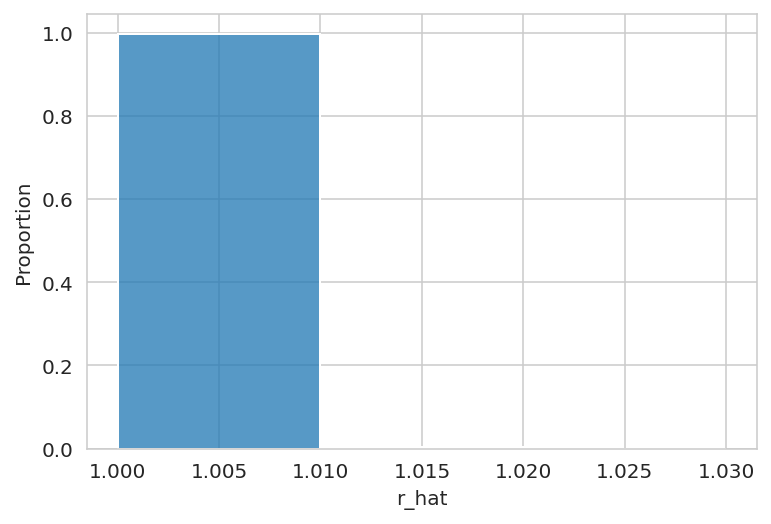

In [13]:
sns.histplot(x=prostate_post_summary["r_hat"], binwidth=0.01, stat="proportion");

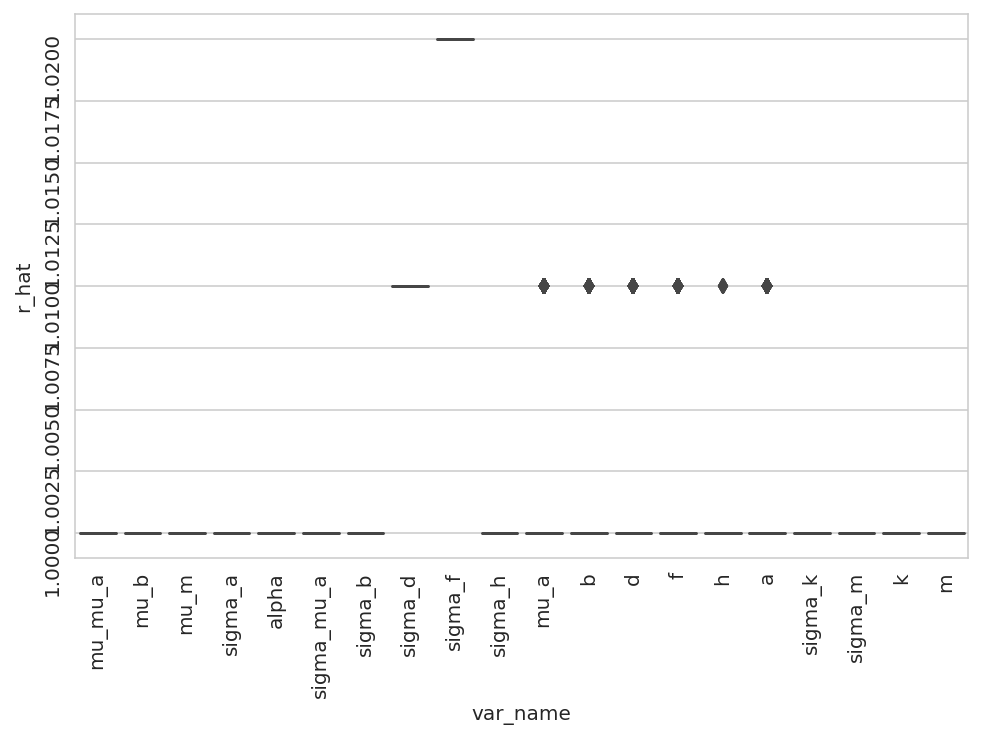

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=prostate_post_summary, x="var_name", y="r_hat", ax=ax)
ax.tick_params(rotation=90)
plt.show()

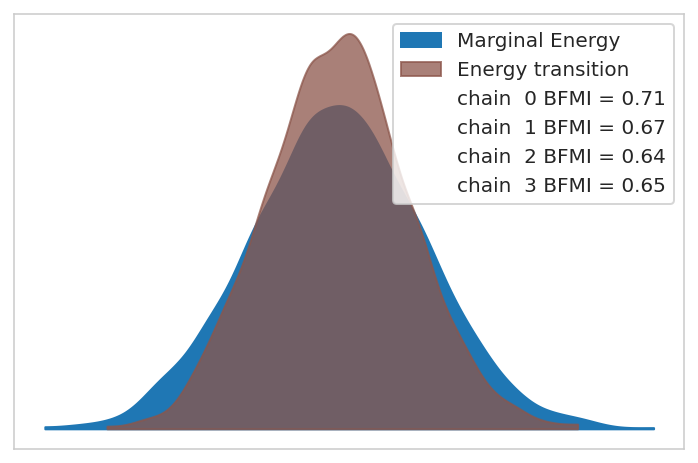

In [15]:
az.plot_energy(trace);

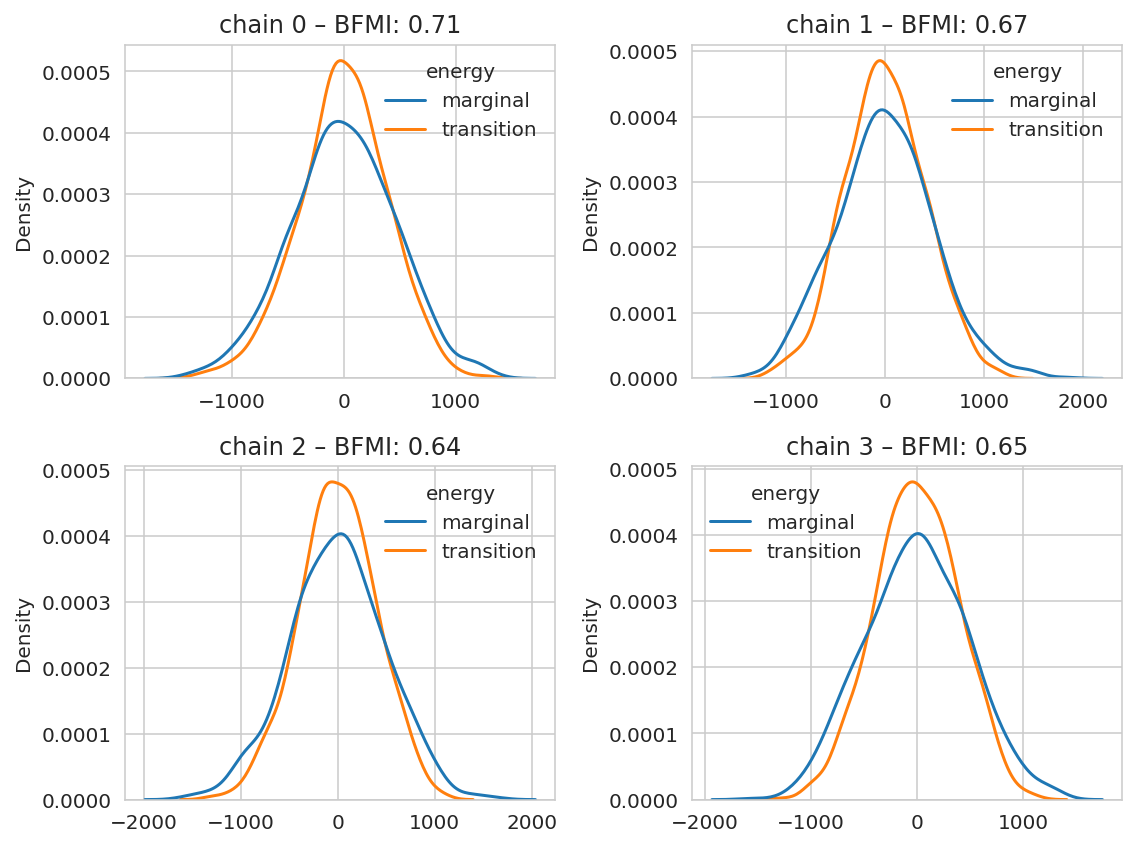

In [16]:
energy = trace.sample_stats.energy.values
marginal_e = pd.DataFrame((energy - energy.mean(axis=1)[:, None]).T).assign(
    energy="marginal"
)
transition_e = pd.DataFrame((energy[:, :-1] - energy[:, 1:]).T).assign(
    energy="transition"
)
energy_df = pd.concat([marginal_e, transition_e]).reset_index(drop=True)
bfmi = az.bfmi(trace)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
for i, ax in enumerate(axes.flatten()):
    sns.kdeplot(data=energy_df, x=i, hue="energy", ax=ax)
    ax.set_title(f"chain {i} – BFMI: {bfmi[i]:0.2f}")
    ax.set_xlabel(None)
    xmin, _ = ax.get_xlim()
    _, ymax = ax.get_ylim()
    ax.get_legend().set_frame_on(False)

fig.tight_layout()
plt.show()

In [17]:
stats = ["step_size", "n_steps", "tree_depth", "acceptance_rate", "energy"]
trace.sample_stats.get(stats).to_dataframe().groupby("chain").mean()

step_size   n_steps  tree_depth  acceptance_rate        energy
chain                                                                
0       0.007800   511.000       9.000         0.974795  2.454580e+06
1       0.005113  1023.000      10.000         0.985641  2.454498e+06
2       0.008123   510.656       8.999         0.968869  2.454528e+06
3       0.006444   510.740       8.999         0.978201  2.454606e+06

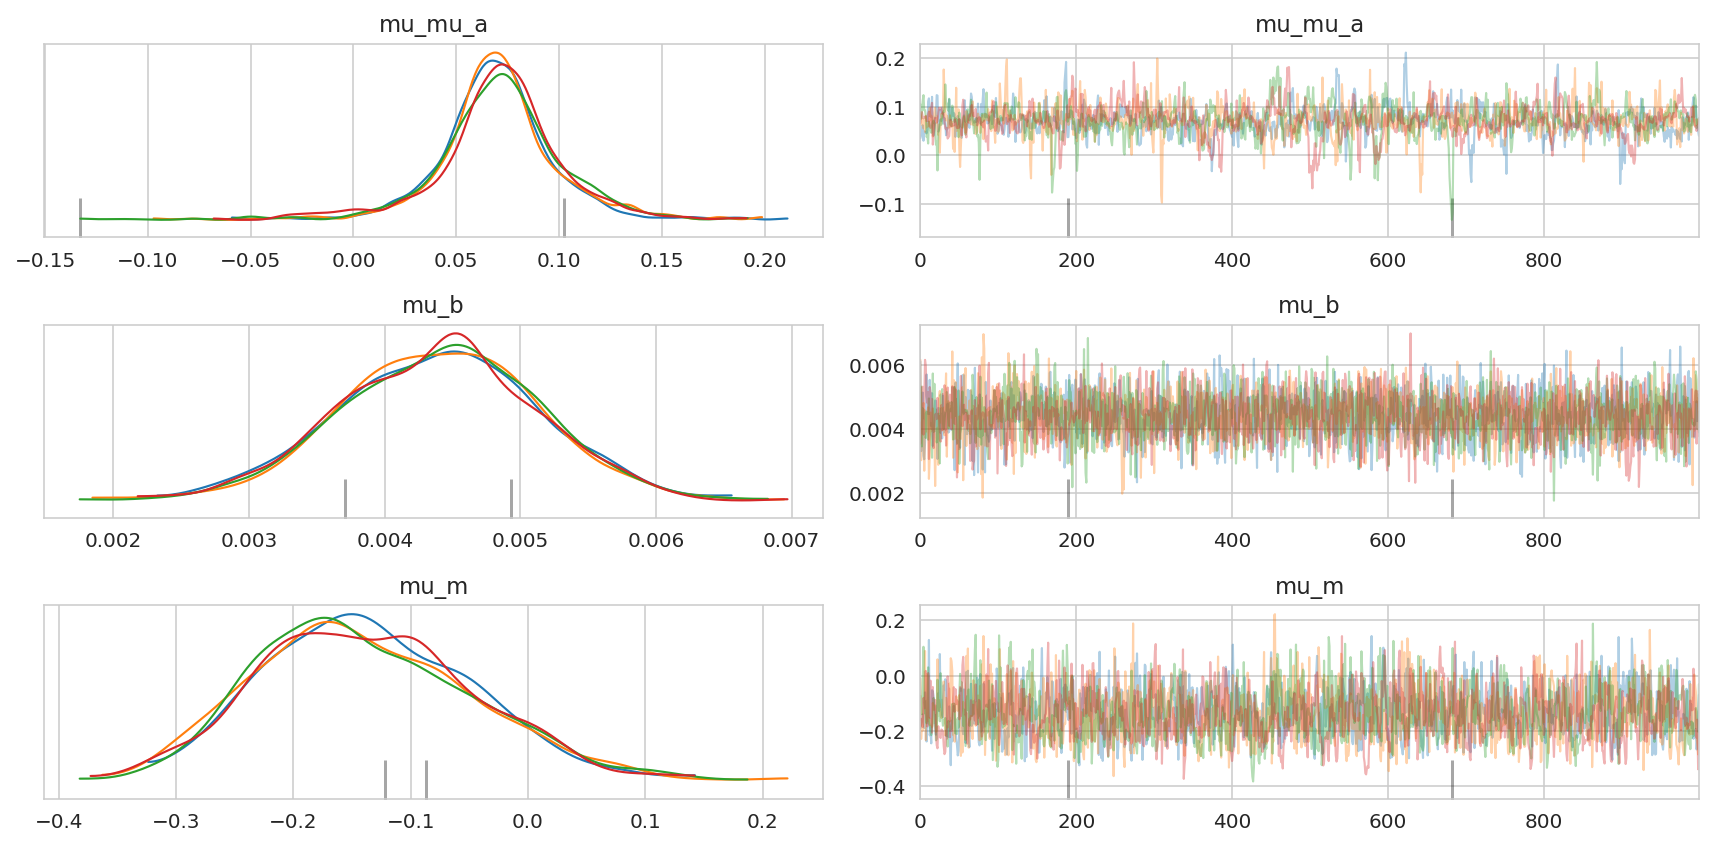

In [18]:
az.plot_trace(trace, var_names=["mu_mu_a", "mu_b", "mu_m"], compact=False)
plt.tight_layout()

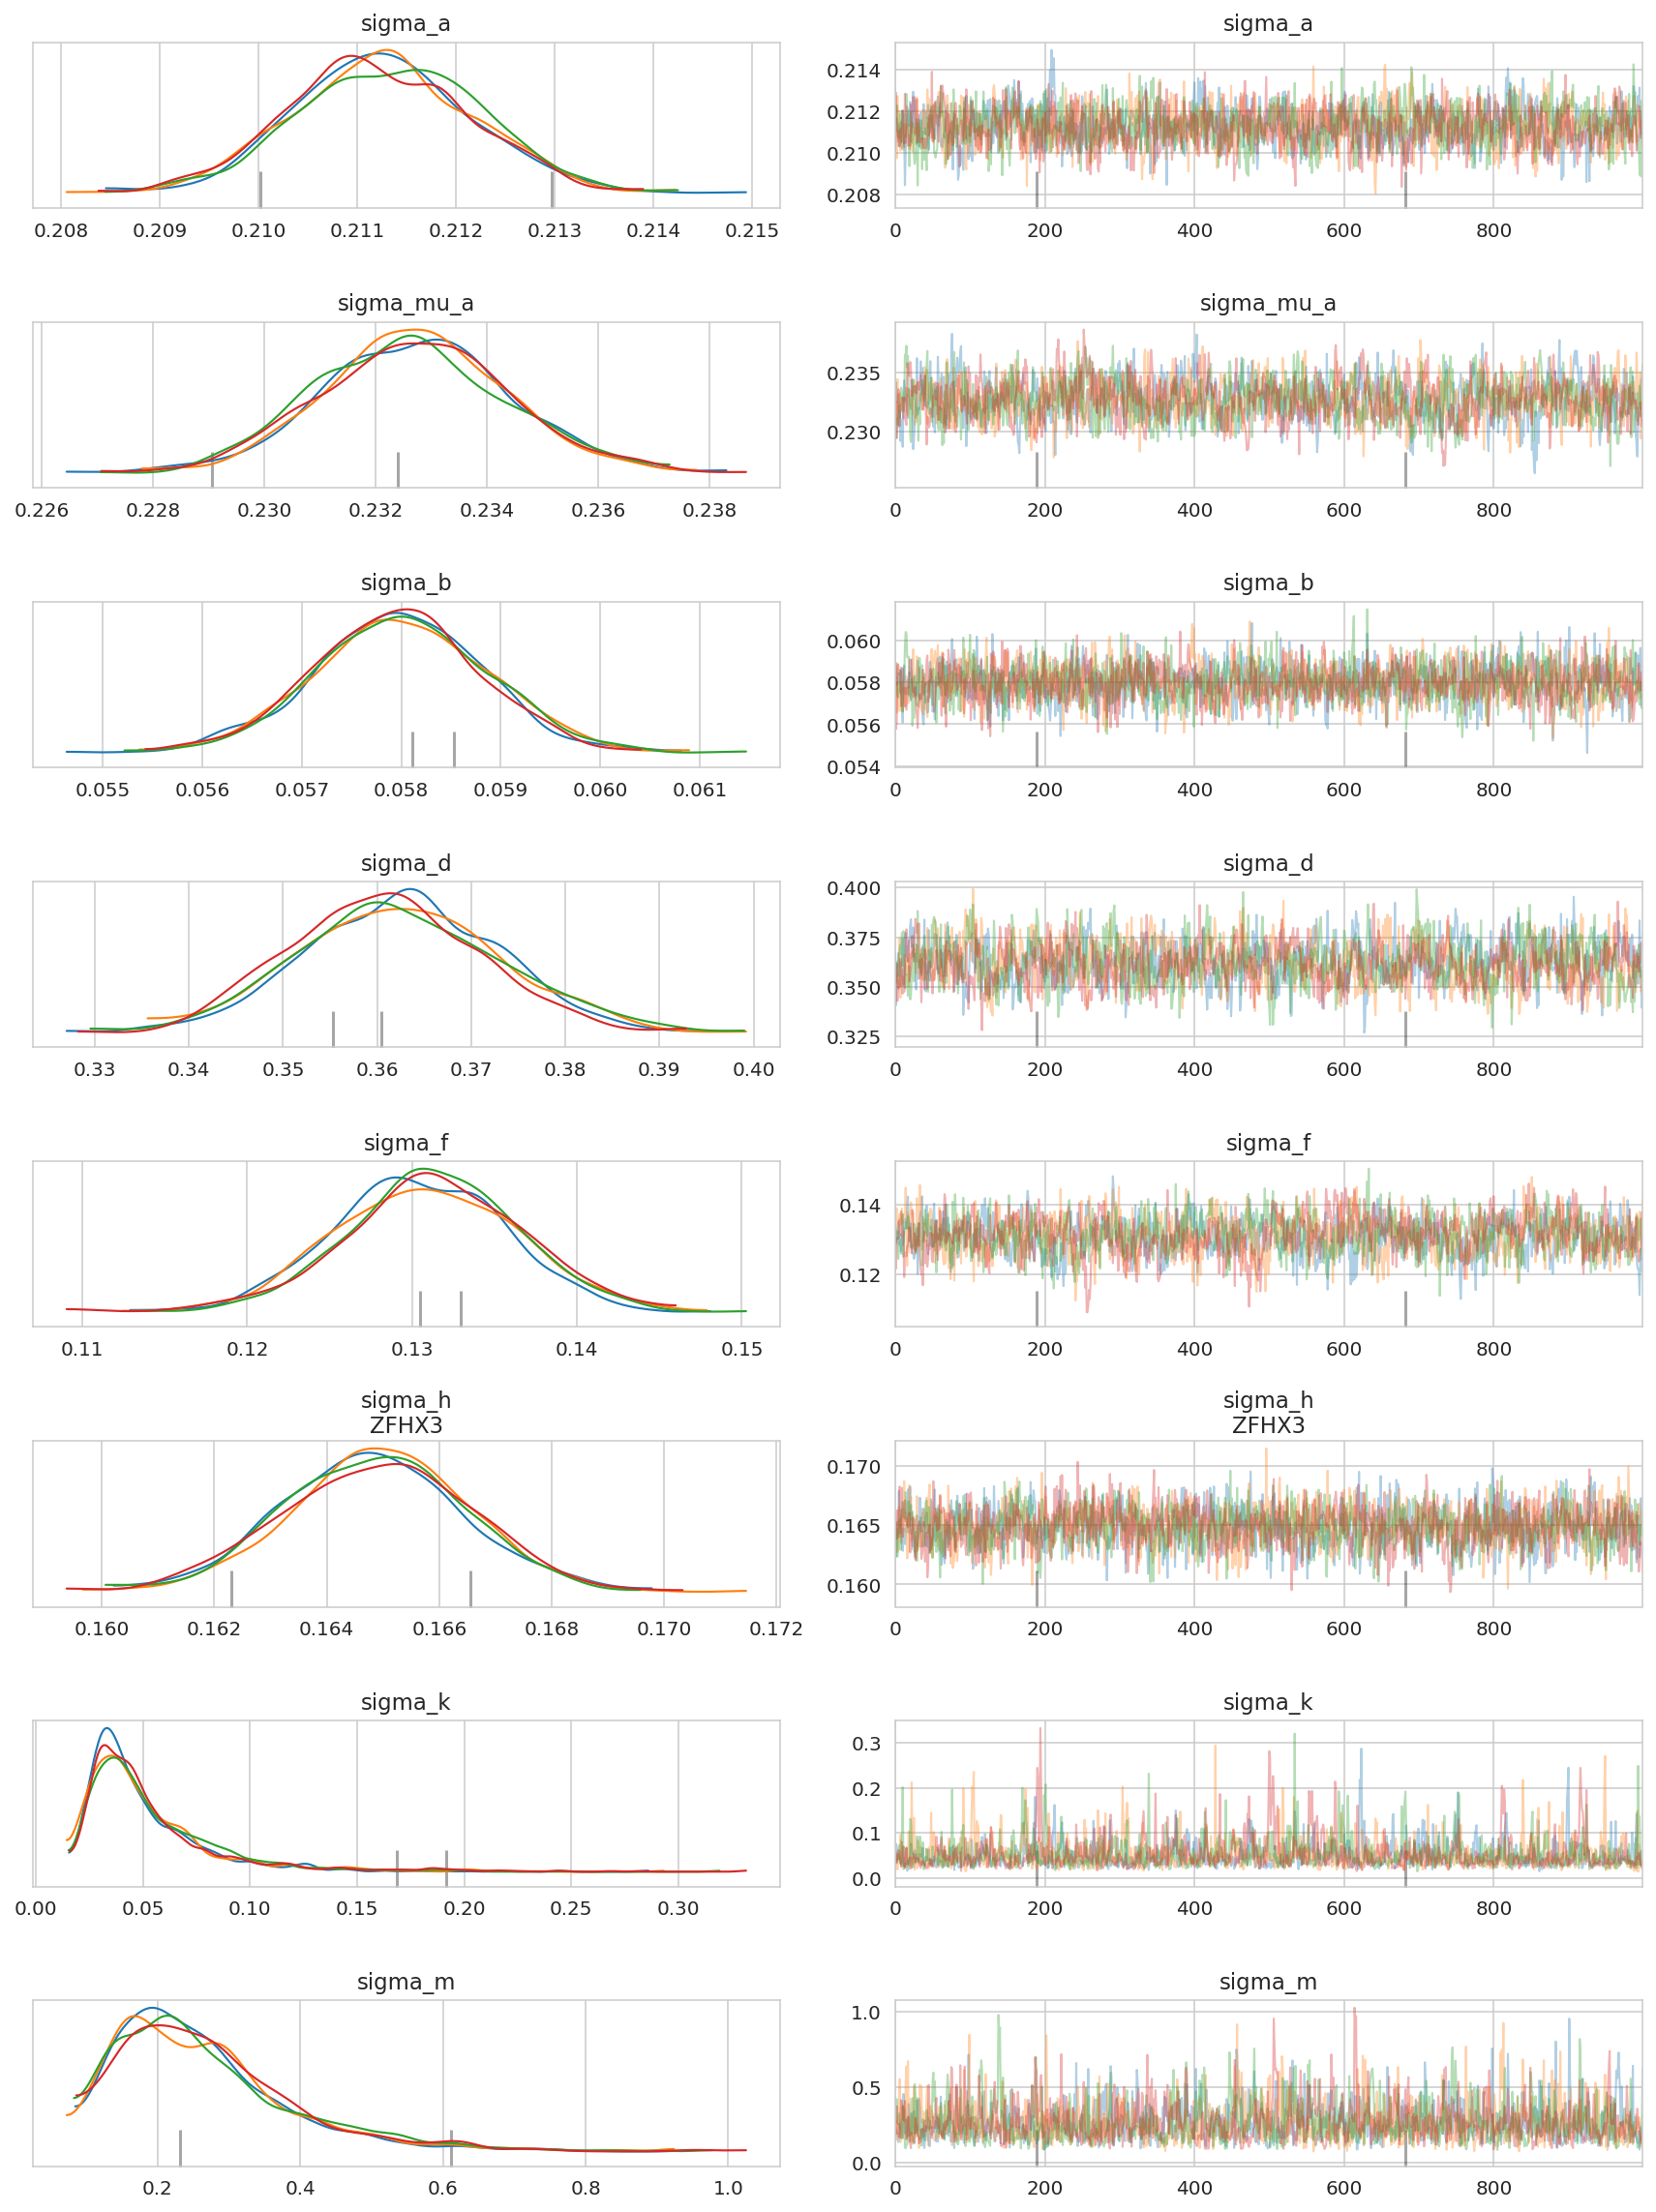

In [19]:
az.plot_trace(trace, var_names=["^sigma_*"], filter_vars="regex", compact=False)
plt.tight_layout()

In [20]:
sigmas = ["sigma_mu_a", "sigma_b", "sigma_d", "sigma_f", "sigma_k"]
trace.posterior.get(sigmas).mean(dim="draw").to_dataframe()

sigma_mu_a   sigma_b   sigma_d   sigma_f   sigma_k
chain                                                    
0        0.232725  0.057965  0.362670  0.130369  0.050080
1        0.232729  0.058007  0.362389  0.130891  0.052314
2        0.232592  0.058024  0.362526  0.131373  0.055044
3        0.232707  0.057935  0.360703  0.131303  0.054217

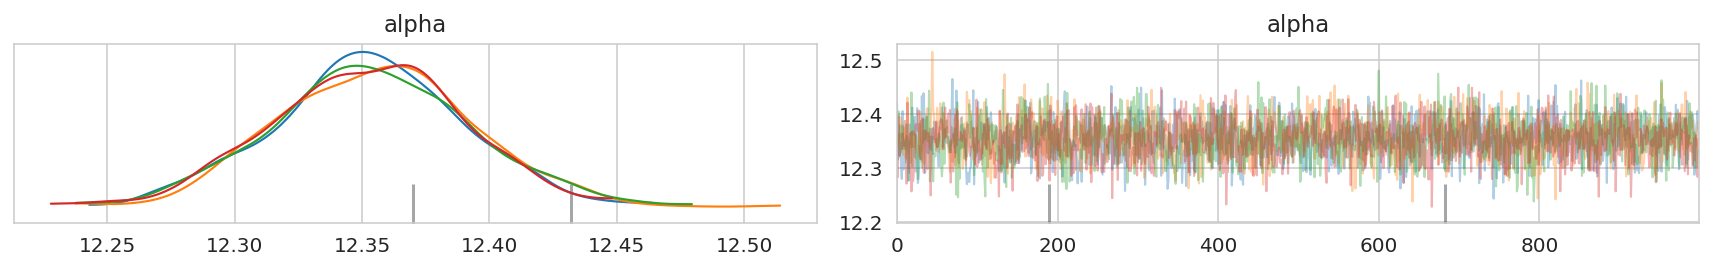

In [21]:
az.plot_trace(trace, var_names=["alpha"], compact=False)
plt.tight_layout()

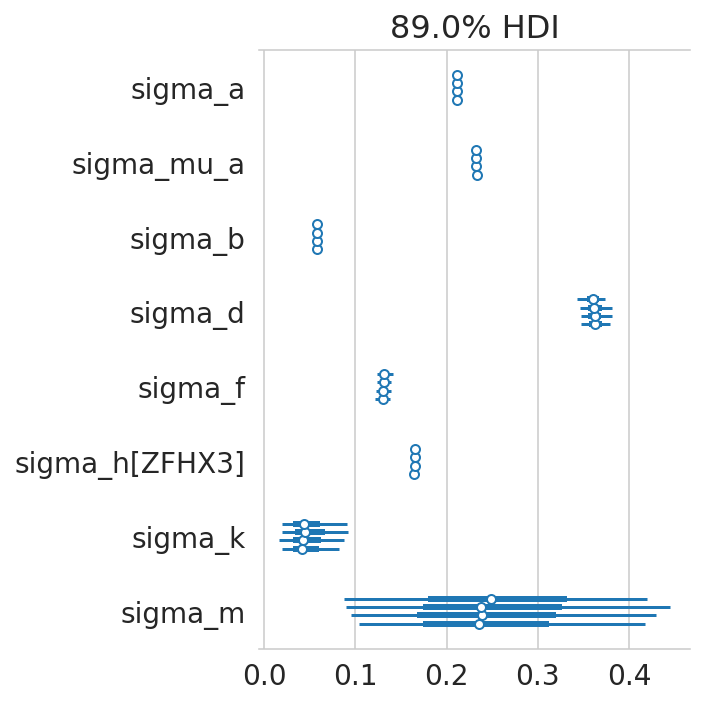

In [22]:
az.plot_forest(
    trace, var_names=["^sigma_*"], filter_vars="regex", combined=False, figsize=(5, 5)
)
plt.tight_layout()

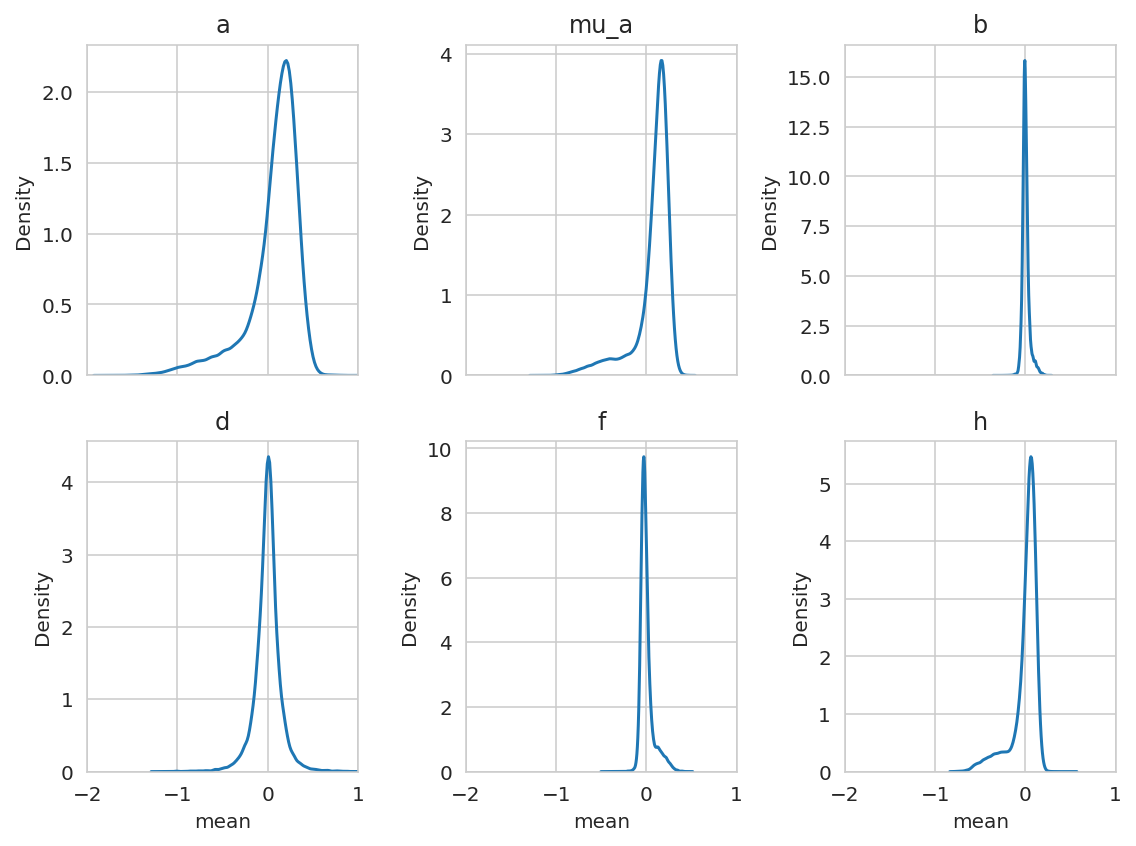

In [23]:
var_names = ["a", "mu_a", "b", "d", "f", "h"]
_, axes = plt.subplots(2, 3, figsize=(8, 6), sharex=True)
for ax, var_name in zip(axes.flatten(), var_names):
    x = prostate_post_summary.query(f"var_name == '{var_name}'")["mean"]
    sns.kdeplot(x=x, ax=ax)
    ax.set_title(var_name)
    ax.set_xlim(-2, 1)

plt.tight_layout()
plt.show()

In [24]:
sgrna_to_gene_map = (
    prostate_data.copy()[["hugo_symbol", "sgrna"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

In [25]:
from IPython.display import Markdown, display

In [26]:
for v in ["mu_a", "b", "d", "f", "h", "k", "m"]:
    display(Markdown(f"variable: **{v}**"))
    top = (
        prostate_post_summary.query(f"var_name == '{v}'")
        .sort_values("mean")
        .pipe(head_tail, 5)
    )
    display(top)

variable: **mu_a**

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
7784      mu_a[KIF11] -1.205  0.104    -1.372     -1.038      0.002    0.002   
6986      mu_a[HSPE1] -1.044  0.101    -1.214     -0.894      0.002    0.002   
14743     mu_a[SPC24] -1.034  0.105    -1.210     -0.875      0.003    0.002   
12652       mu_a[RAN] -1.020  0.101    -1.179     -0.862      0.002    0.001   
4543       mu_a[EEF2] -0.989  0.100    -1.146     -0.826      0.002    0.002   
2454       mu_a[CCNF]  0.393  0.106     0.230      0.564      0.003    0.002   
17715    mu_a[ZNF334]  0.394  0.107     0.218      0.554      0.002    0.002   
12056   mu_a[PRAMEF4]  0.399  0.100     0.239      0.554      0.002    0.002   
16213      mu_a[TP53]  0.432  0.097     0.273      0.581      0.002    0.002   
6761   mu_a[HLA-DQB1]  0.451  0.106     0.280      0.624      0.002    0.002   

       ess_bulk  ess_tail  r_hat var_name  
7784     1971.0    2730.0    1.0     mu_a  
6986     2199.0    2708.0    1.0     mu_a  
14743    1753.0    2486.0    1.0     mu_a  
12652    2311.0    2896.0    1.0     mu_a  
4543     1856.0    2470.0    1.0     mu_a  
2454     1769.0    2544.0    1.0     mu_a  
17715    2122.0    2695.0    1.0     mu_a  
12056    1761.0    2475.0    1.0     mu_a  
16213    1994.0    2511.0    1.0     mu_a  
6761     2257.0    2796.0    1.0     mu_a

variable: **b**

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
22901    b[EP300] -0.343  0.042    -0.413     -0.278      0.001      0.0   
34343     b[TP63] -0.192  0.041    -0.258     -0.127      0.001      0.0   
33382    b[TADA1] -0.183  0.040    -0.247     -0.122      0.001      0.0   
33097    b[STAG2] -0.177  0.041    -0.239     -0.110      0.001      0.0   
24975   b[HOXB13] -0.172  0.045    -0.245     -0.103      0.001      0.0   
27993  b[NDUFB11]  0.225  0.042     0.163      0.296      0.001      0.0   
19385  b[ATP6V1F]  0.229  0.044     0.161      0.299      0.001      0.0   
24315      b[GPI]  0.243  0.047     0.171      0.320      0.001      0.0   
27883    b[NARS2]  0.250  0.042     0.183      0.317      0.001      0.0   
18590    b[AIFM1]  0.276  0.043     0.209      0.344      0.001      0.0   

       ess_bulk  ess_tail  r_hat var_name  
22901    4673.0    2904.0    1.0        b  
34343    5435.0    3177.0    1.0        b  
33382    5993.0    2807.0    1.0        b  
33097    4806.0    3252.0    1.0        b  
24975    5697.0    2996.0    1.0        b  
27993    5793.0    3306.0    1.0        b  
19385    5863.0    2699.0    1.0        b  
24315    6015.0    2815.0    1.0        b  
27883    5992.0    2777.0    1.0        b  
18590    5939.0    3039.0    1.0        b

variable: **d**

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
52954   d[UBE2N] -1.229  0.258    -1.650     -0.841      0.004    0.003   
39455   d[CNOT1] -1.079  0.298    -1.559     -0.615      0.004    0.003   
44097    d[KLF5] -1.018  0.255    -1.438     -0.622      0.004    0.003   
44641   d[LONP1] -1.014  0.327    -1.565     -0.517      0.005    0.003   
40722   d[EARS2] -1.014  0.320    -1.525     -0.512      0.004    0.003   
45695   d[MSMO1]  0.932  0.319     0.417      1.433      0.005    0.004   
45607  d[MRPL39]  0.973  0.285     0.490      1.405      0.004    0.003   
48704    d[PWP2]  0.998  0.234     0.621      1.364      0.003    0.002   
43702   d[ITGB1]  1.083  0.271     0.649      1.510      0.004    0.003   
40412   d[DMAC1]  1.263  0.263     0.826      1.659      0.004    0.003   

       ess_bulk  ess_tail  r_hat var_name  
52954    4876.0    2986.0    1.0        d  
39455    5750.0    2862.0    1.0        d  
44097    4223.0    2944.0    1.0        d  
44641    4695.0    2834.0    1.0        d  
40722    5092.0    3049.0    1.0        d  
45695    4043.0    2552.0    1.0        d  
45607    4838.0    3210.0    1.0        d  
48704    5561.0    3273.0    1.0        d  
43702    4392.0    2903.0    1.0        d  
40412    5343.0    2995.0    1.0        d

variable: **f**

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
59139   f[EP300] -0.474  0.108    -0.639     -0.298      0.002    0.001   
69335   f[STAG2] -0.301  0.105    -0.469     -0.133      0.002    0.001   
55242      f[AR] -0.247  0.107    -0.417     -0.078      0.001    0.001   
61869    f[JAG1] -0.214  0.095    -0.360     -0.061      0.001    0.001   
63323   f[MED13] -0.213  0.103    -0.362     -0.040      0.002    0.001   
70552   f[TOP2A]  0.398  0.109     0.219      0.567      0.002    0.001   
60672    f[GRB2]  0.398  0.105     0.229      0.563      0.001    0.001   
62926    f[LSM2]  0.408  0.103     0.244      0.567      0.002    0.001   
68887  f[SNAP23]  0.430  0.108     0.254      0.599      0.002    0.001   
66937   f[RAB6A]  0.482  0.106     0.312      0.646      0.002    0.001   

       ess_bulk  ess_tail  r_hat var_name  
59139    4008.0    3165.0    1.0        f  
69335    3745.0    2442.0    1.0        f  
55242    5496.0    3129.0    1.0        f  
61869    4689.0    2816.0    1.0        f  
63323    4541.0    2579.0    1.0        f  
70552    3118.0    2776.0    1.0        f  
60672    4907.0    2666.0    1.0        f  
62926    4436.0    2568.0    1.0        f  
68887    4208.0    3087.0    1.0        f  
66937    4067.0    2603.0    1.0        f

variable: **h**

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  \
80260     h[KIF11, ZFHX3] -0.777  0.089    -0.915     -0.633      0.001   
77154       h[ELL, ZFHX3] -0.776  0.083    -0.901     -0.640      0.001   
88899     h[TRNT1, ZFHX3] -0.746  0.080    -0.879     -0.627      0.001   
85774     h[RPS4X, ZFHX3] -0.734  0.080    -0.863     -0.607      0.001   
80879     h[LONP1, ZFHX3] -0.730  0.088    -0.873     -0.592      0.001   
72882      h[AFF4, ZFHX3]  0.255  0.071     0.145      0.369      0.001   
79237  h[HLA-DQB1, ZFHX3]  0.262  0.082     0.130      0.392      0.001   
77165      h[ELOA, ZFHX3]  0.263  0.074     0.152      0.387      0.001   
88689      h[TP53, ZFHX3]  0.328  0.073     0.215      0.444      0.001   
77258     h[EP300, ZFHX3]  0.510  0.079     0.386      0.632      0.001   

       mcse_sd  ess_bulk  ess_tail  r_hat var_name  
80260    0.001    5093.0    2995.0    1.0        h  
77154    0.001    4579.0    2887.0    1.0        h  
88899    0.001    4180.0    2517.0    1.0        h  
85774    0.001    5811.0    3202.0    1.0        h  
80879    0.001    4153.0    3233.0    1.0        h  
72882    0.001    4399.0    3230.0    1.0        h  
79237    0.001    4473.0    2823.0    1.0        h  
77165    0.001    4596.0    3450.0    1.0        h  
88689    0.001    5112.0    2910.0    1.0        h  
77258    0.001    4071.0    3088.0    1.0        h

variable: **k**

parameter   mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
161672  k[ACH-001627] -0.038  0.03    -0.089      0.002      0.001    0.001   
161670  k[ACH-000977] -0.037  0.03    -0.088      0.003      0.001    0.001   
161671  k[ACH-001453] -0.010  0.03    -0.060      0.030      0.001    0.001   
161673  k[ACH-001648]  0.011  0.03    -0.039      0.052      0.001    0.001   
161669  k[ACH-000115]  0.032  0.03    -0.019      0.072      0.001    0.001   
161672  k[ACH-001627] -0.038  0.03    -0.089      0.002      0.001    0.001   
161670  k[ACH-000977] -0.037  0.03    -0.088      0.003      0.001    0.001   
161671  k[ACH-001453] -0.010  0.03    -0.060      0.030      0.001    0.001   
161673  k[ACH-001648]  0.011  0.03    -0.039      0.052      0.001    0.001   
161669  k[ACH-000115]  0.032  0.03    -0.019      0.072      0.001    0.001   

        ess_bulk  ess_tail  r_hat var_name  
161672     720.0     932.0    1.0        k  
161670     735.0    1010.0    1.0        k  
161671     739.0     993.0    1.0        k  
161673     748.0     992.0    1.0        k  
161669     750.0     959.0    1.0        k  
161672     720.0     932.0    1.0        k  
161670     735.0    1010.0    1.0        k  
161671     739.0     993.0    1.0        k  
161673     748.0     992.0    1.0        k  
161669     750.0     959.0    1.0        k

variable: **m**

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
161675  m[ACH-000977] -0.528  0.017    -0.557     -0.501        0.0      0.0   
161676  m[ACH-001453] -0.255  0.011    -0.275     -0.239        0.0      0.0   
161674  m[ACH-000115] -0.246  0.009    -0.261     -0.232        0.0      0.0   
161677  m[ACH-001627] -0.230  0.014    -0.253     -0.207        0.0      0.0   
161678  m[ACH-001648] -0.194  0.011    -0.209     -0.176        0.0      0.0   
161675  m[ACH-000977] -0.528  0.017    -0.557     -0.501        0.0      0.0   
161676  m[ACH-001453] -0.255  0.011    -0.275     -0.239        0.0      0.0   
161674  m[ACH-000115] -0.246  0.009    -0.261     -0.232        0.0      0.0   
161677  m[ACH-001627] -0.230  0.014    -0.253     -0.207        0.0      0.0   
161678  m[ACH-001648] -0.194  0.011    -0.209     -0.176        0.0      0.0   

        ess_bulk  ess_tail  r_hat var_name  
161675    4368.0    3683.0    1.0        m  
161676    4303.0    3766.0    1.0        m  
161674    4141.0    3484.0    1.0        m  
161677    4627.0    3812.0    1.0        m  
161678    4403.0    3720.0    1.0        m  
161675    4368.0    3683.0    1.0        m  
161676    4303.0    3766.0    1.0        m  
161674    4141.0    3484.0    1.0        m  
161677    4627.0    3812.0    1.0        m  
161678    4403.0    3720.0    1.0        m

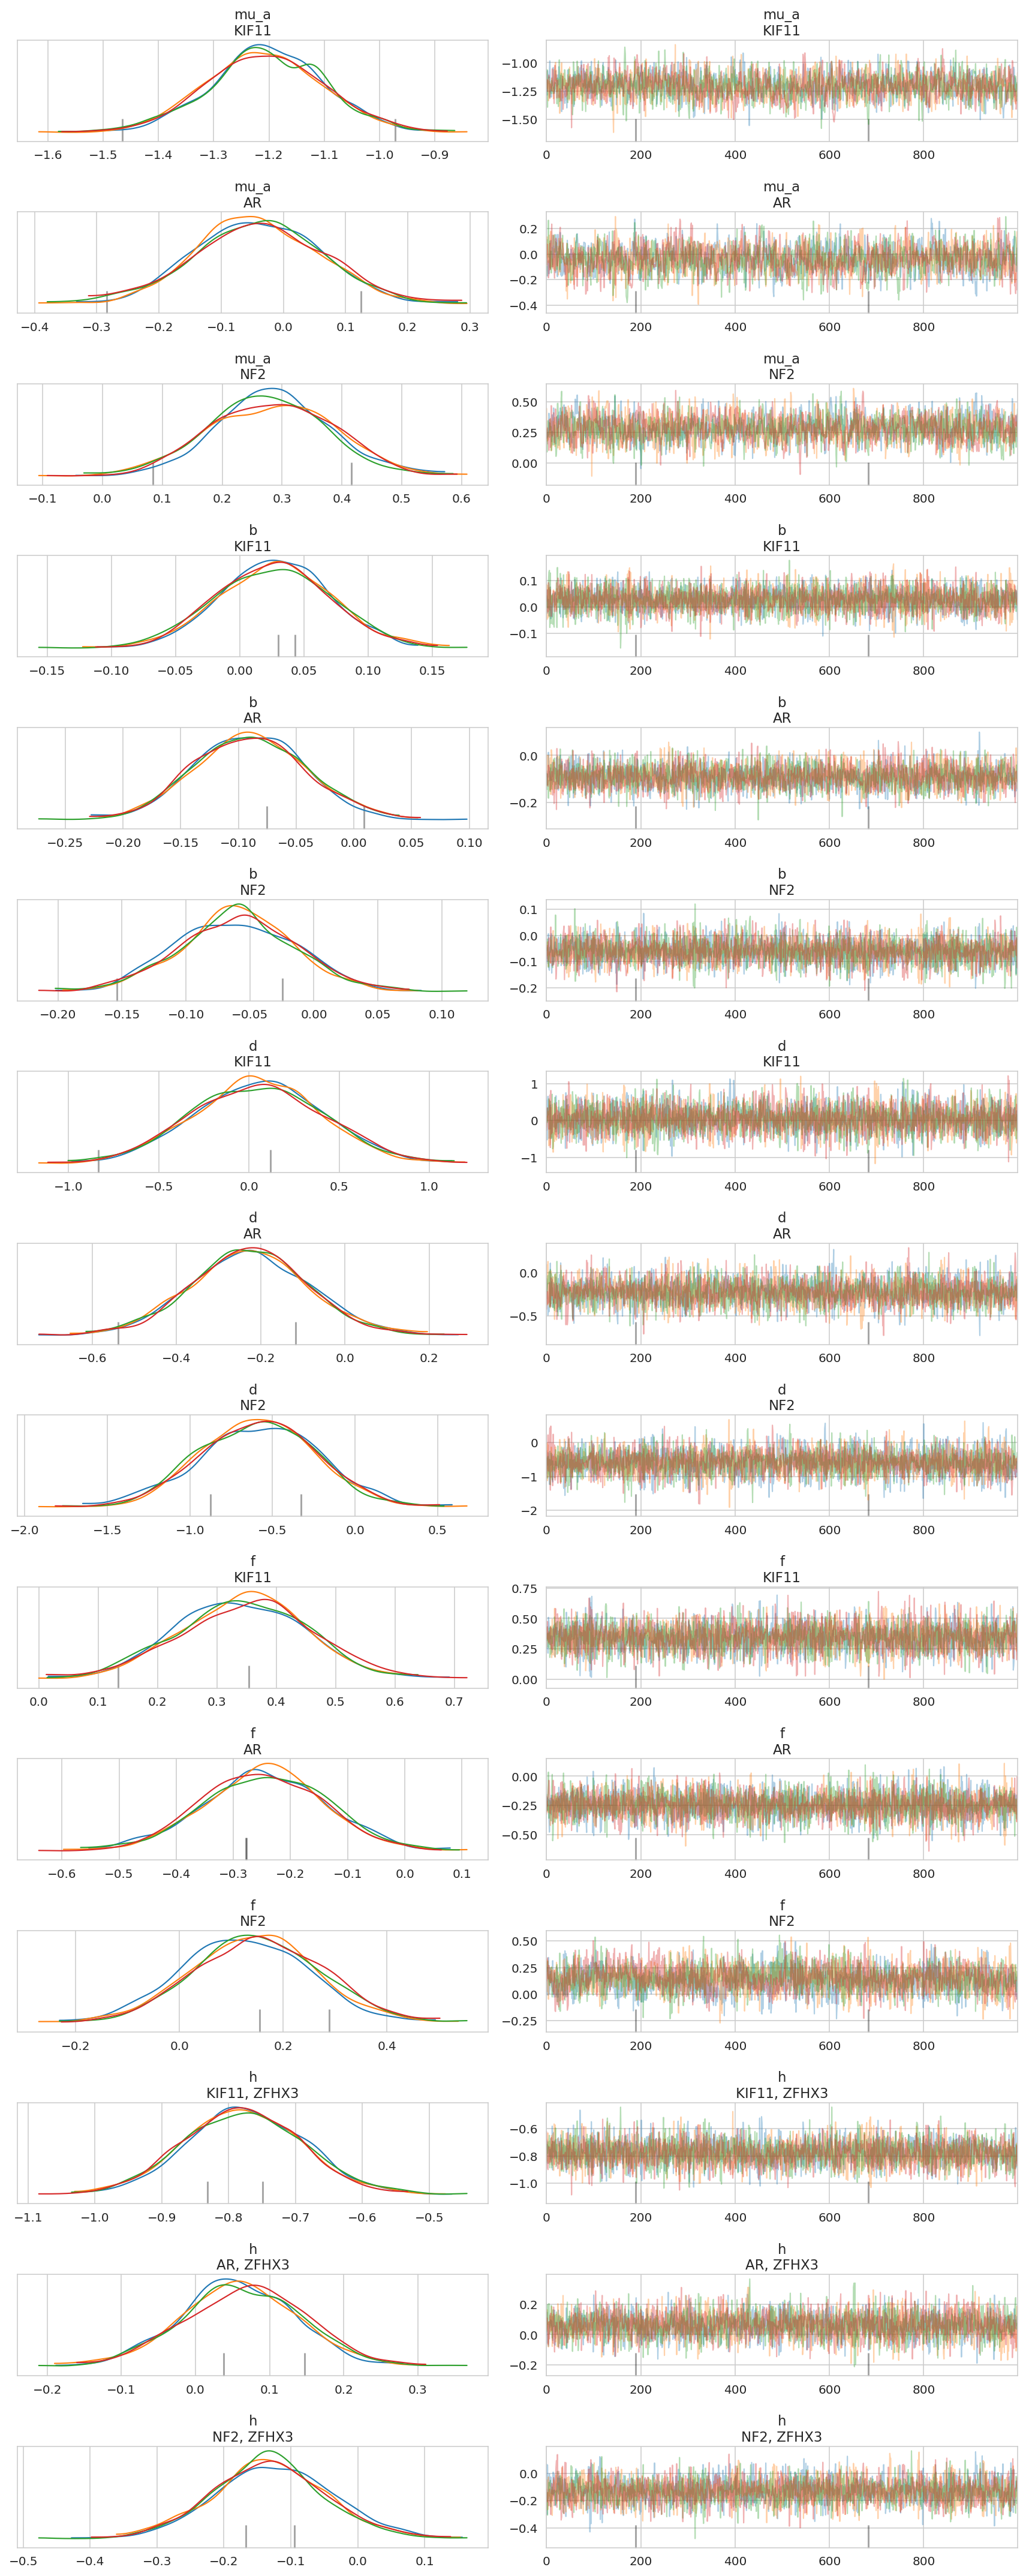

In [27]:
example_genes = ["KIF11", "AR", "NF2"]
az.plot_trace(
    trace,
    var_names=["mu_a", "b", "d", "f", "h"],
    coords={"gene": example_genes},
    compact=False,
)
plt.tight_layout()
plt.show()

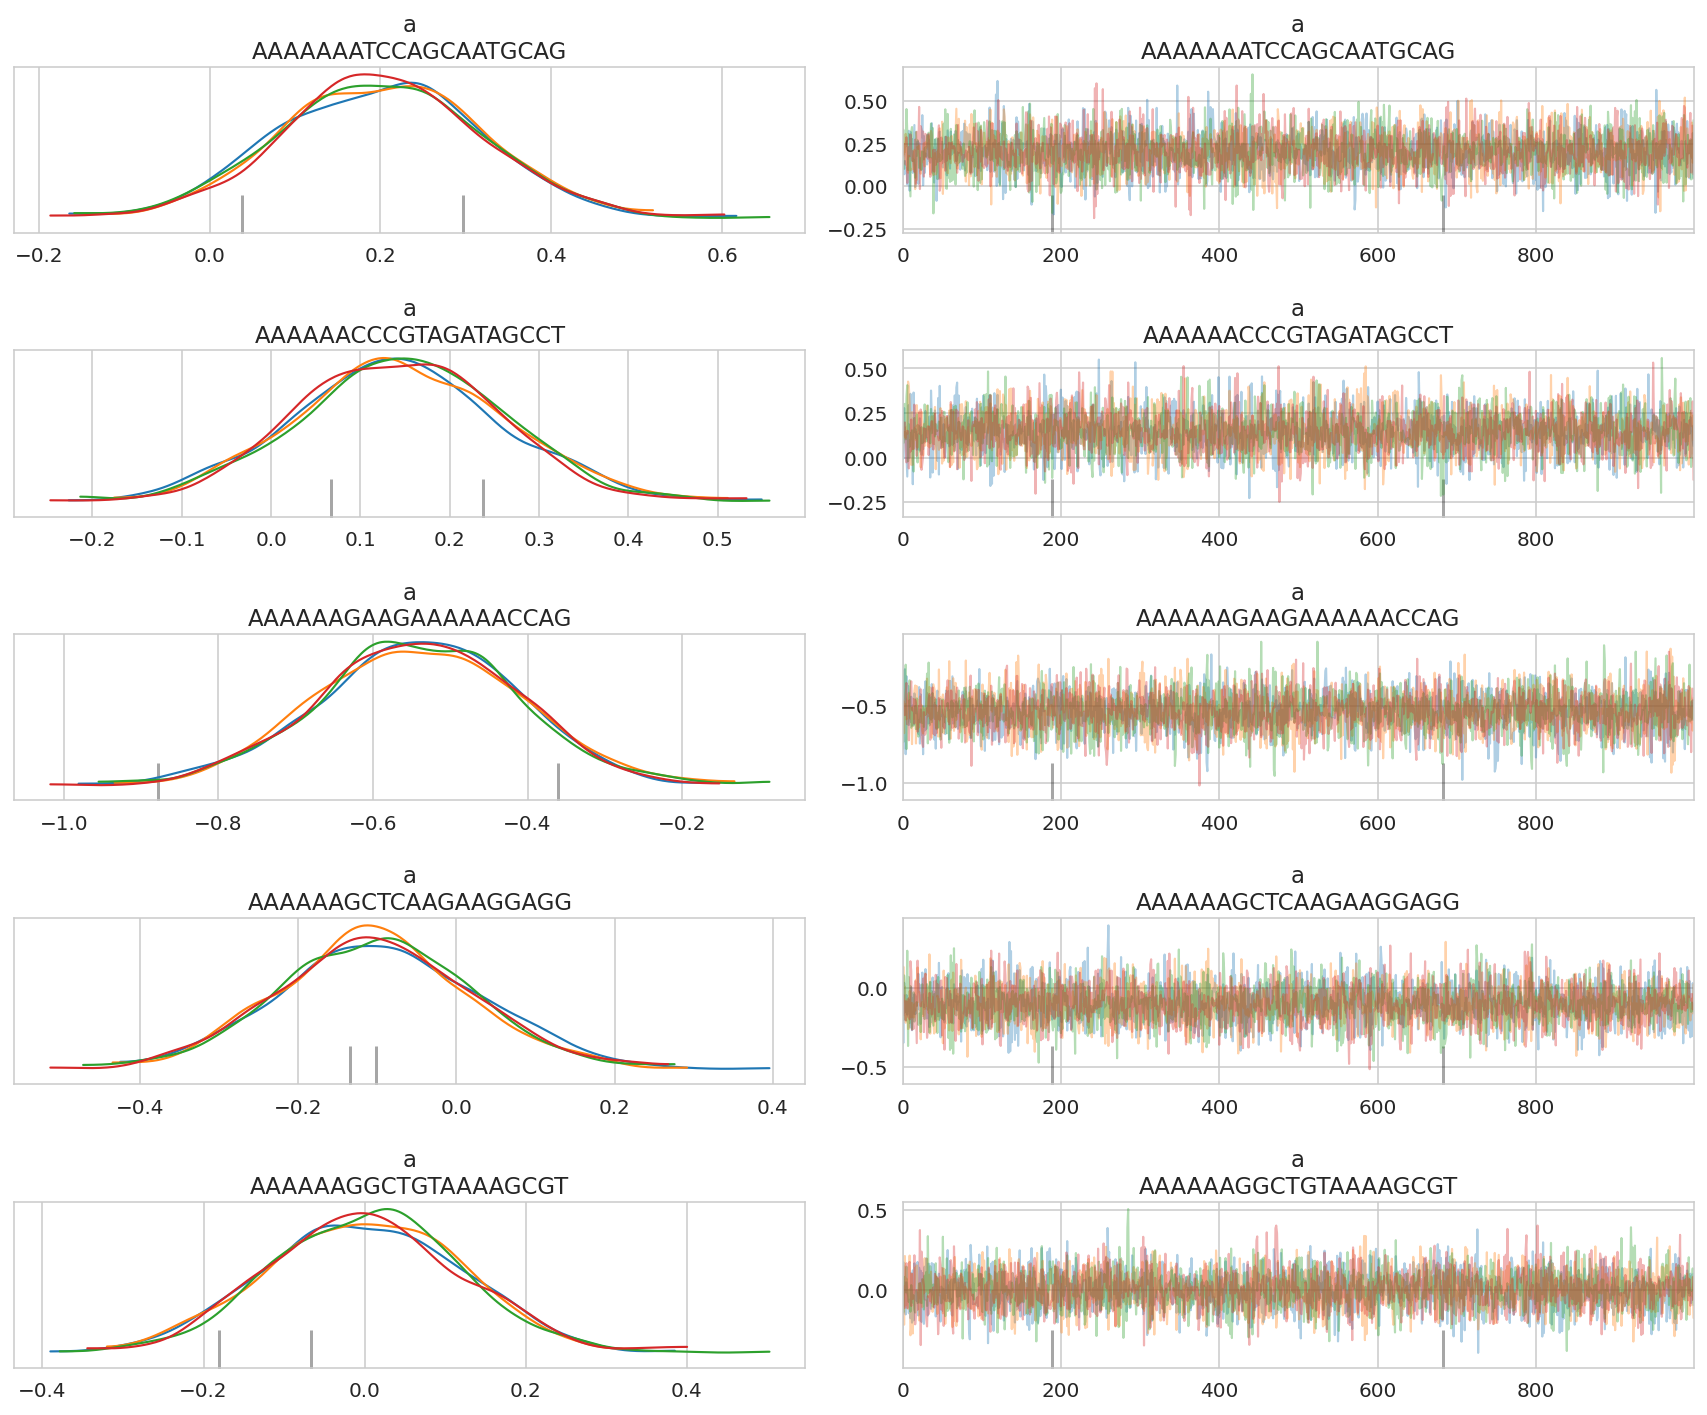

In [28]:
sgrnas_sample = trace.posterior.coords["sgrna"].values[:5]

az.plot_trace(trace, var_names="a", coords={"sgrna": sgrnas_sample}, compact=False)
plt.tight_layout()
plt.show()

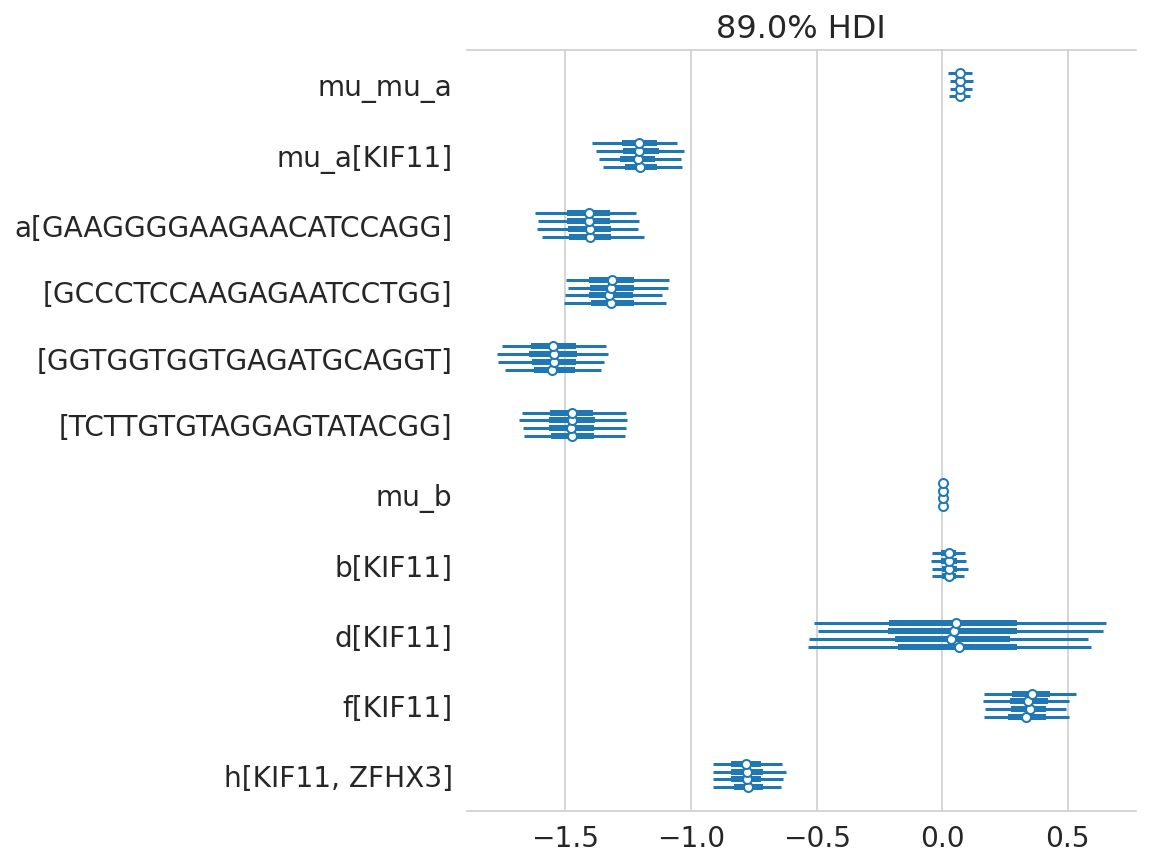

In [29]:
example_gene = "KIF11"
example_gene_sgrna = sgrna_to_gene_map.query(f"hugo_symbol == '{example_gene}'")[
    "sgrna"
].tolist()
az.plot_forest(
    trace,
    var_names=[
        "mu_mu_a",
        "mu_a",
        "a",
        "mu_b",
        "b",
        "d",
        "f",
        "h",
    ],
    coords={"gene": [example_gene], "sgrna": example_gene_sgrna},
    combined=False,
    figsize=(6, 7),
)
plt.show()

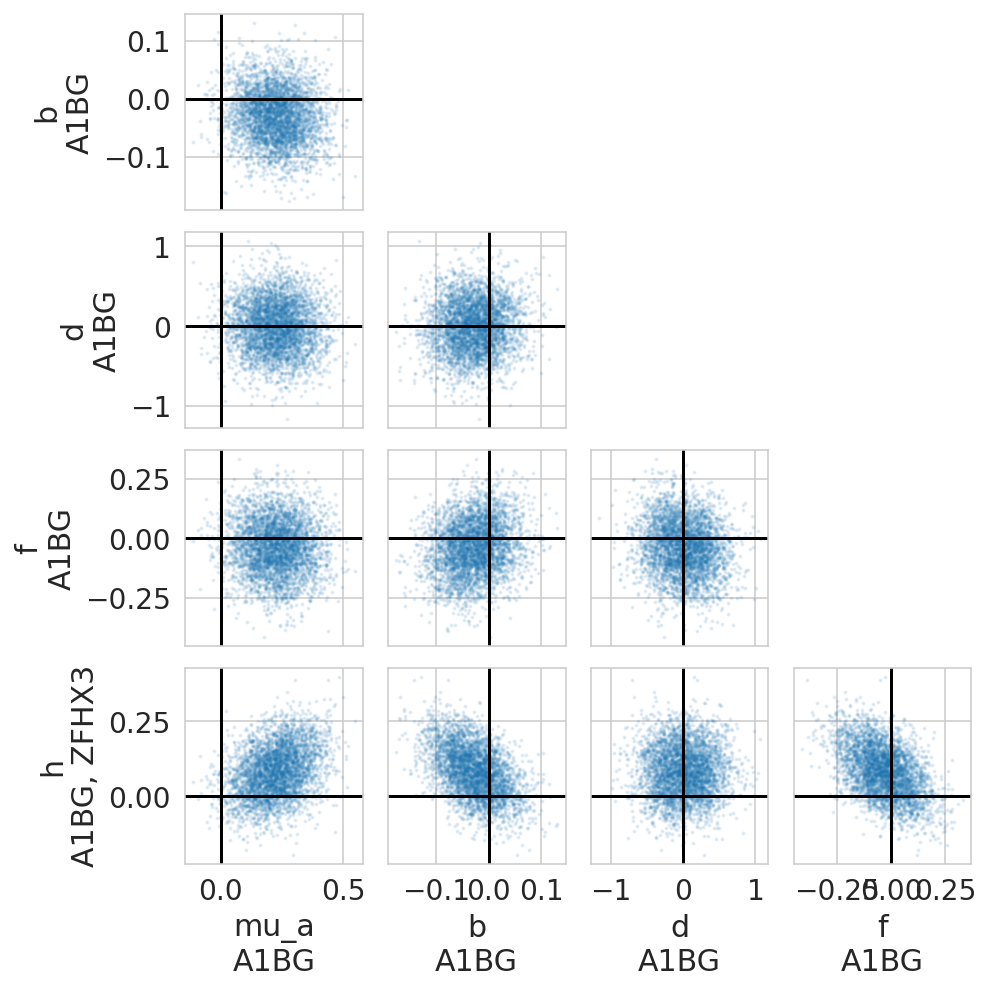

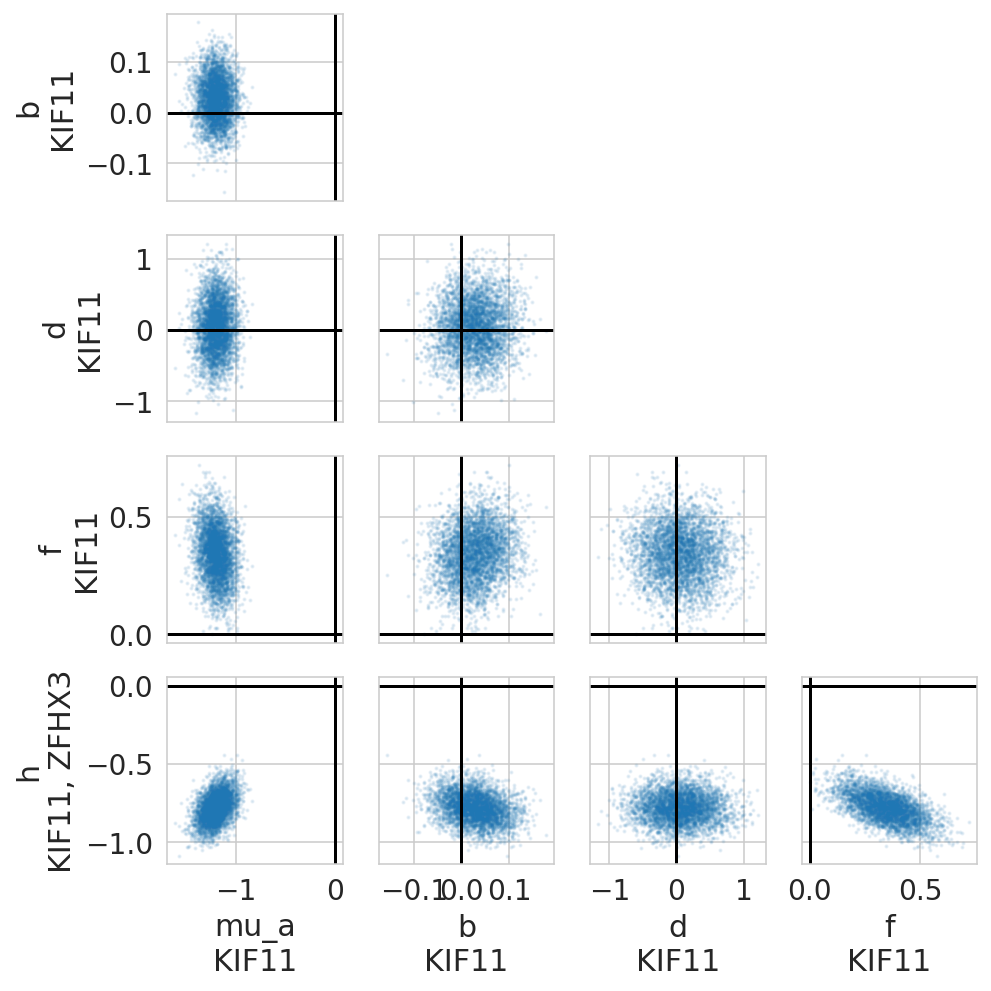

In [30]:
eg_gene = trace.posterior.coords["gene"].values[0]

for gene in [eg_gene, "KIF11"]:
    axes = az.plot_pair(
        trace,
        var_names=["mu_a", "b", "d", "f", "h"],
        coords={"gene": [gene]},
        figsize=(7, 7),
        scatter_kwargs={"alpha": 0.1, "markersize": 2},
    )
    for ax in axes.flatten():
        ax.axhline(0, color="k")
        ax.axvline(0, color="k")
    plt.tight_layout()
    plt.show()

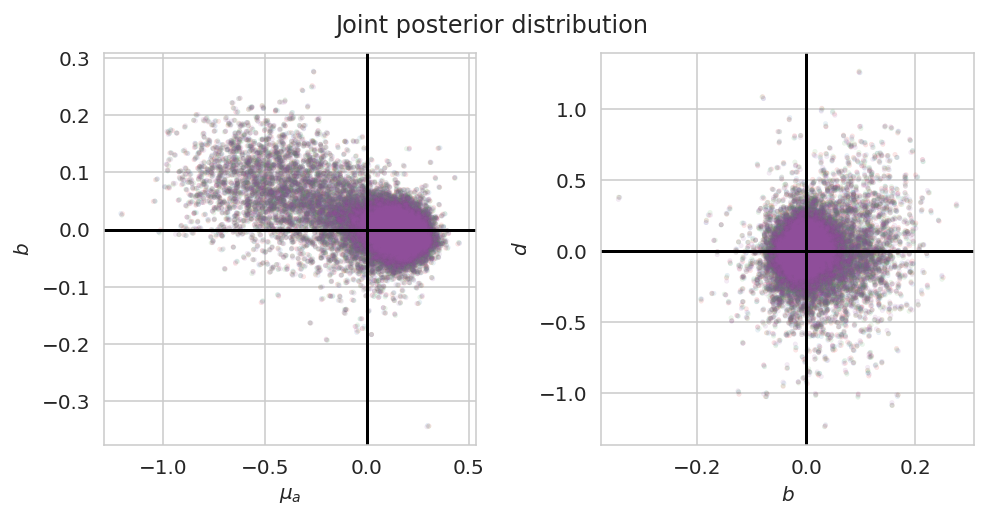

In [31]:
def _get_average_per_chain(trace: az.InferenceData, var_name: str) -> pd.DataFrame:
    return (
        trace.posterior[var_name]
        .mean(axis=(1))
        .to_dataframe()
        .reset_index()
        .astype({"chain": str})
    )


mu_a_post_avg = _get_average_per_chain(trace, "mu_a")
b_post_avg = _get_average_per_chain(trace, "b")
d_post_avg = _get_average_per_chain(trace, "d")

gene_post_avg = mu_a_post_avg.merge(b_post_avg, on=["chain", "gene"]).merge(
    d_post_avg, on=["chain", "gene"]
)


fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(7, 3.5))

ax = axes[0]
sns.scatterplot(
    data=gene_post_avg,
    x="mu_a",
    y="b",
    hue="chain",
    palette="Set1",
    alpha=0.1,
    edgecolor=None,
    s=5,
    ax=ax,
)
ax.set_xlabel(r"$\mu_a$")
ax.set_ylabel(r"$b$")


ax = axes[1]
sns.scatterplot(
    data=gene_post_avg,
    x="b",
    y="d",
    hue="chain",
    palette="Set1",
    alpha=0.1,
    edgecolor=None,
    s=5,
    ax=ax,
)
ax.set_xlabel(r"$b$")
ax.set_ylabel(r"$d$")

for ax in axes.flatten():
    ax.axhline(color="k")
    ax.axvline(color="k")
    ax.get_legend().remove()


fig.tight_layout()
fig.suptitle("Joint posterior distribution", va="bottom")

plt.show()

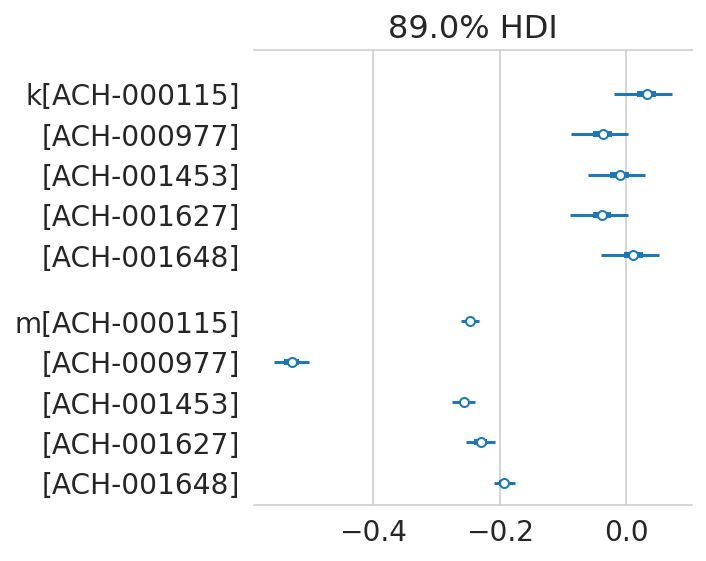

In [32]:
az.plot_forest(trace, var_names=["k", "m"], combined=True, figsize=(5, 4))
plt.tight_layout()
plt.show()

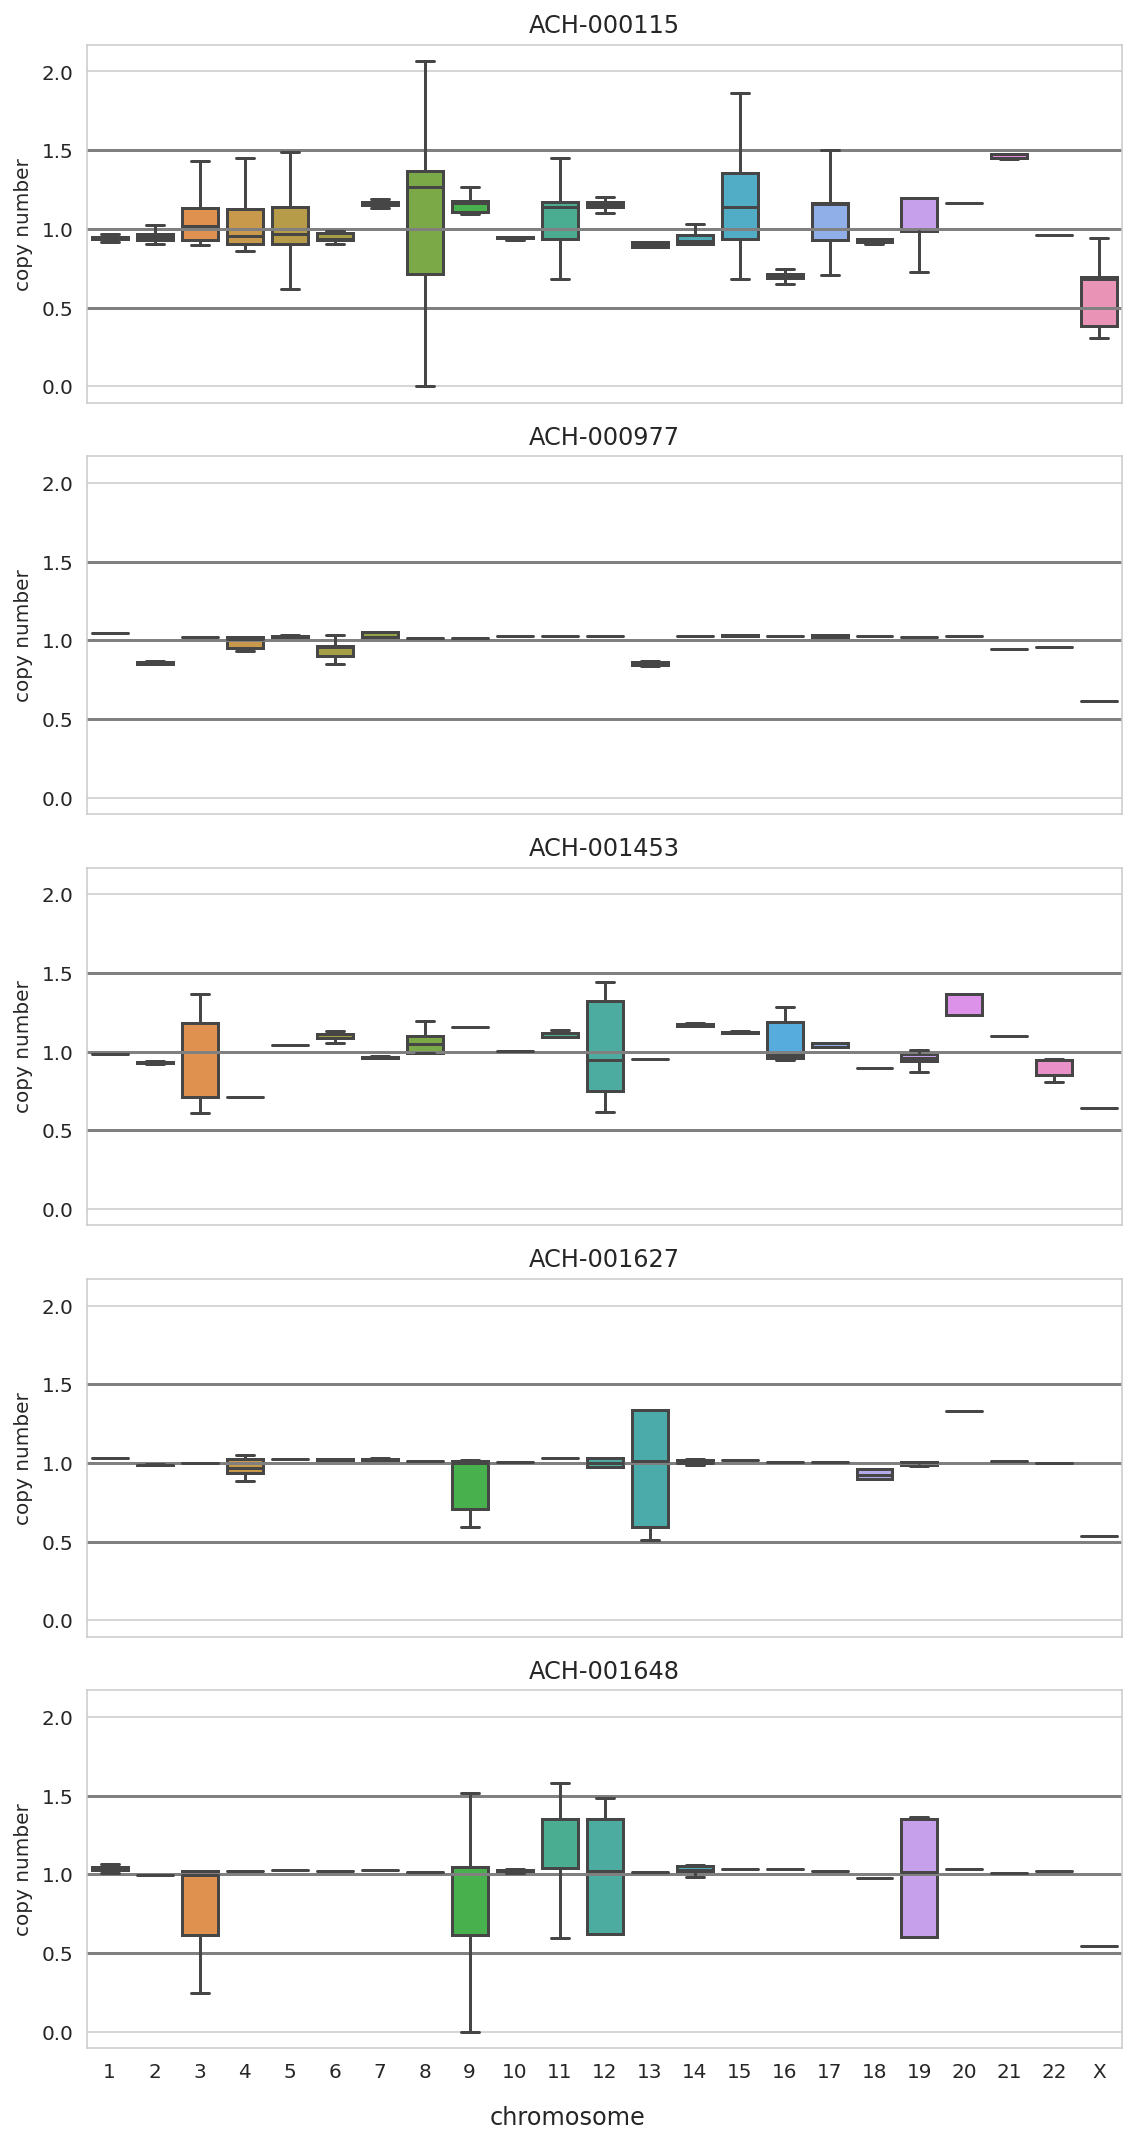

In [33]:
chr_order = list(np.arange(1, 23).astype(str)) + ["X"]

cn_data = (
    valid_prostate_data.copy()[
        ["hugo_symbol", "depmap_id", "sgrna_target_chr", "copy_number"]
    ]
    .drop_duplicates()
    .assign(
        sgrna_target_chr=lambda d: pd.Categorical(
            d["sgrna_target_chr"], categories=chr_order
        )
    )
)
n_cells = cn_data["depmap_id"].nunique()


fig, axes = plt.subplots(
    nrows=n_cells, figsize=(8, n_cells * 3), sharex=True, sharey=True
)
for ax, (cell, data_cell) in zip(axes.flatten(), cn_data.groupby("depmap_id")):
    ax.set_title(cell)
    for y in [0.5, 1, 1.5]:
        ax.axhline(y=y, color="gray", zorder=1)
    sns.boxplot(
        data=data_cell,
        x="sgrna_target_chr",
        y="copy_number",
        ax=ax,
        showfliers=False,
        zorder=5,
    )
    ax.set_xlabel(None)
    ax.set_ylabel("copy number")

fig.supxlabel("chromosome")
fig.tight_layout()
plt.show()

In [34]:
genes_var_names = ["mu_a", "b", "d", "f"]
genes_var_names += [f"h[{g}]" for g in trace.posterior.coords["cancer_gene"].values]
gene_corr_post = (
    az.summary(trace, "genes_chol_cov_corr", kind="stats")
    .pipe(extract_coords_param_names, names=["d1", "d2"])
    .astype({"d1": int, "d2": int})
    .assign(
        p1=lambda d: [genes_var_names[i] for i in d["d1"]],
        p2=lambda d: [genes_var_names[i] for i in d["d2"]],
    )
    .assign(
        p1=lambda d: pd.Categorical(d["p1"], categories=d["p1"].unique(), ordered=True)
    )
    .assign(
        p2=lambda d: pd.Categorical(
            d["p2"], categories=d["p1"].cat.categories, ordered=True
        )
    )
)
gene_corr_post

mean     sd  hdi_5.5%  hdi_94.5%  d1  d2  \
genes_chol_cov_corr[0, 0]  1.000  0.000     1.000      1.000   0   0   
genes_chol_cov_corr[0, 1] -0.372  0.014    -0.396     -0.350   0   1   
genes_chol_cov_corr[0, 2]  0.072  0.023     0.036      0.108   0   2   
genes_chol_cov_corr[0, 3] -0.484  0.035    -0.541     -0.430   0   3   
genes_chol_cov_corr[0, 4]  0.841  0.010     0.825      0.856   0   4   
genes_chol_cov_corr[1, 0] -0.372  0.014    -0.396     -0.350   1   0   
genes_chol_cov_corr[1, 1]  1.000  0.000     1.000      1.000   1   1   
genes_chol_cov_corr[1, 2] -0.010  0.032    -0.058      0.043   1   2   
genes_chol_cov_corr[1, 3]  0.316  0.050     0.239      0.398   1   3   
genes_chol_cov_corr[1, 4] -0.506  0.016    -0.530     -0.481   1   4   
genes_chol_cov_corr[2, 0]  0.072  0.023     0.036      0.108   2   0   
genes_chol_cov_corr[2, 1] -0.010  0.032    -0.058      0.043   2   1   
genes_chol_cov_corr[2, 2]  1.000  0.000     1.000      1.000   2   2   
genes_chol_cov_corr[2, 3] -0.100  0.077    -0.222      0.024   2   3   
genes_chol_cov_corr[2, 4]  0.036  0.025    -0.003      0.078   2   4   
genes_chol_cov_corr[3, 0] -0.484  0.035    -0.541     -0.430   3   0   
genes_chol_cov_corr[3, 1]  0.316  0.050     0.239      0.398   3   1   
genes_chol_cov_corr[3, 2] -0.100  0.077    -0.222      0.024   3   2   
genes_chol_cov_corr[3, 3]  1.000  0.000     1.000      1.000   3   3   
genes_chol_cov_corr[3, 4] -0.653  0.028    -0.698     -0.607   3   4   
genes_chol_cov_corr[4, 0]  0.841  0.010     0.825      0.856   4   0   
genes_chol_cov_corr[4, 1] -0.506  0.016    -0.530     -0.481   4   1   
genes_chol_cov_corr[4, 2]  0.036  0.025    -0.003      0.078   4   2   
genes_chol_cov_corr[4, 3] -0.653  0.028    -0.698     -0.607   4   3   
genes_chol_cov_corr[4, 4]  1.000  0.000     1.000      1.000   4   4   

                                 p1        p2  
genes_chol_cov_corr[0, 0]      mu_a      mu_a  
genes_chol_cov_corr[0, 1]      mu_a         b  
genes_chol_cov_corr[0, 2]      mu_a         d  
genes_chol_cov_corr[0, 3]      mu_a         f  
genes_chol_cov_corr[0, 4]      mu_a  h[ZFHX3]  
genes_chol_cov_corr[1, 0]         b      mu_a  
genes_chol_cov_corr[1, 1]         b         b  
genes_chol_cov_corr[1, 2]         b         d  
genes_chol_cov_corr[1, 3]         b         f  
genes_chol_cov_corr[1, 4]         b  h[ZFHX3]  
genes_chol_cov_corr[2, 0]         d      mu_a  
genes_chol_cov_corr[2, 1]         d         b  
genes_chol_cov_corr[2, 2]         d         d  
genes_chol_cov_corr[2, 3]         d         f  
genes_chol_cov_corr[2, 4]         d  h[ZFHX3]  
genes_chol_cov_corr[3, 0]         f      mu_a  
genes_chol_cov_corr[3, 1]         f         b  
genes_chol_cov_corr[3, 2]         f         d  
genes_chol_cov_corr[3, 3]         f         f  
genes_chol_cov_corr[3, 4]         f  h[ZFHX3]  
genes_chol_cov_corr[4, 0]  h[ZFHX3]      mu_a  
genes_chol_cov_corr[4, 1]  h[ZFHX3]         b  
genes_chol_cov_corr[4, 2]  h[ZFHX3]         d  
genes_chol_cov_corr[4, 3]  h[ZFHX3]         f  
genes_chol_cov_corr[4, 4]  h[ZFHX3]  h[ZFHX3]

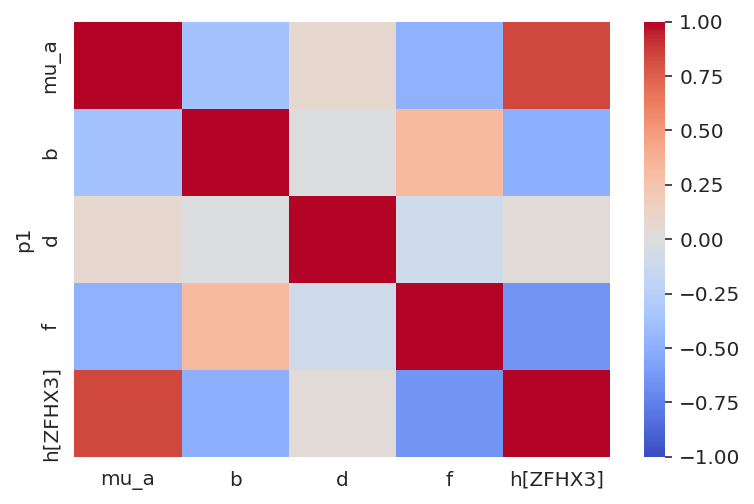

In [35]:
plot_df = gene_corr_post.pivot_wider("p1", "p2", "mean").set_index("p1")
sns.heatmap(plot_df, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

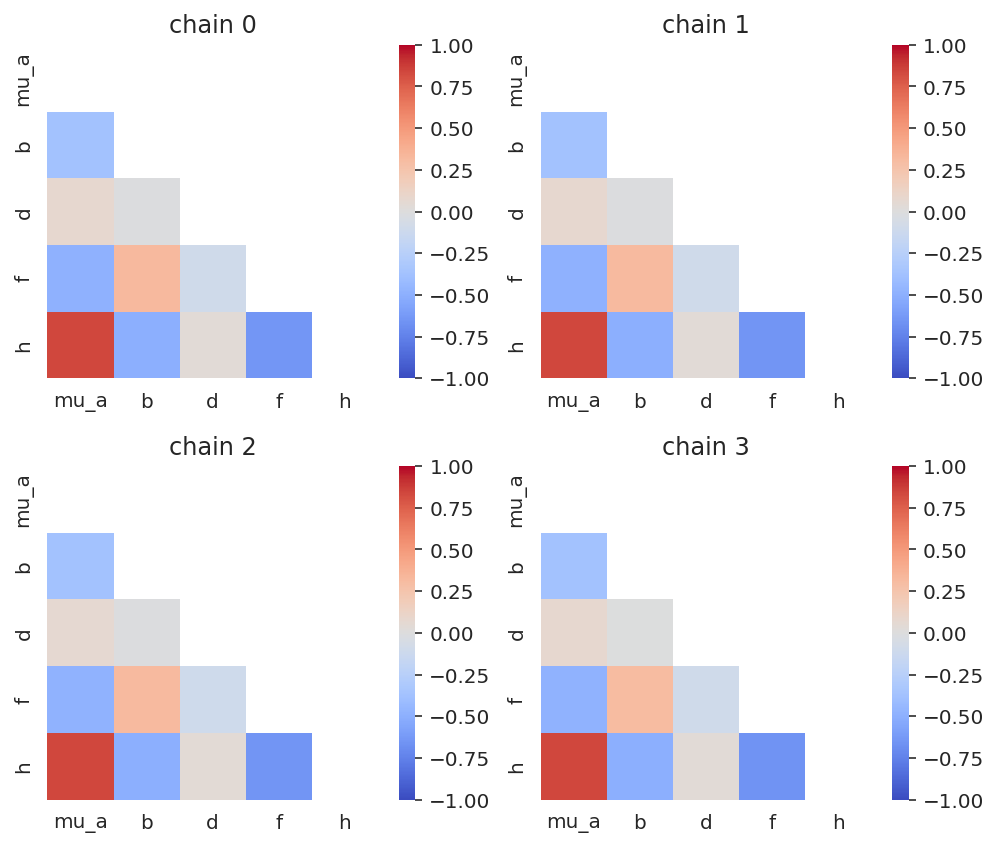

In [36]:
genes_var_corr = trace.posterior["genes_chol_cov_corr"].mean(axis=(1))
genes_var_names = ["mu_a", "b", "d", "f", "h"]
fig, axes = plt.subplots(2, 2, figsize=(7, 6))

for c, ax in enumerate(axes.flatten()):
    data = genes_var_corr[c, :, :].values.copy()
    np.fill_diagonal(data, np.nan)
    data[~np.tril(data).astype(bool)] = np.nan
    sns.heatmap(data, vmin=-1, vmax=1, cmap="coolwarm", ax=ax)
    ax.set_xticklabels(genes_var_names)
    ax.set_yticklabels(genes_var_names)
    ax.set_title(f"chain {c}")

fig.tight_layout()
plt.show()

In [37]:
cancer_genes = trace.posterior.coords["cancer_gene"].values.tolist()
cancer_gene_mutants = (
    valid_prostate_data.filter_column_isin("hugo_symbol", cancer_genes)[
        ["hugo_symbol", "depmap_id", "is_mutated"]
    ]
    .drop_duplicates()
    .assign(is_mutated=lambda d: d["is_mutated"].map({True: "X", False: ""}))
    .pivot_wider("depmap_id", names_from="hugo_symbol", values_from="is_mutated")
    .set_index("depmap_id")
)
cancer_gene_mutants

ZFHX3
depmap_id       
ACH-000115      
ACH-000977     X
ACH-001453      
ACH-001627     X
ACH-001648

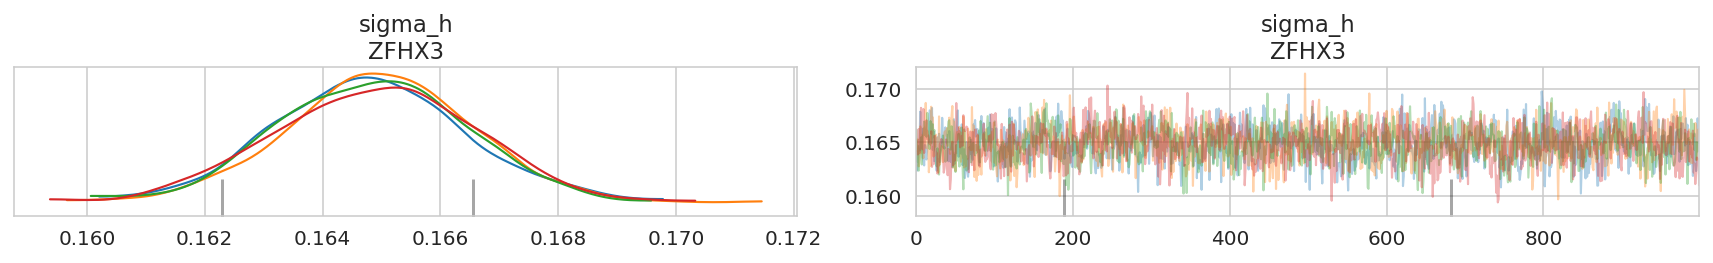

In [38]:
az.plot_trace(trace, var_names=["sigma_h"], compact=False)
plt.tight_layout()
plt.show()

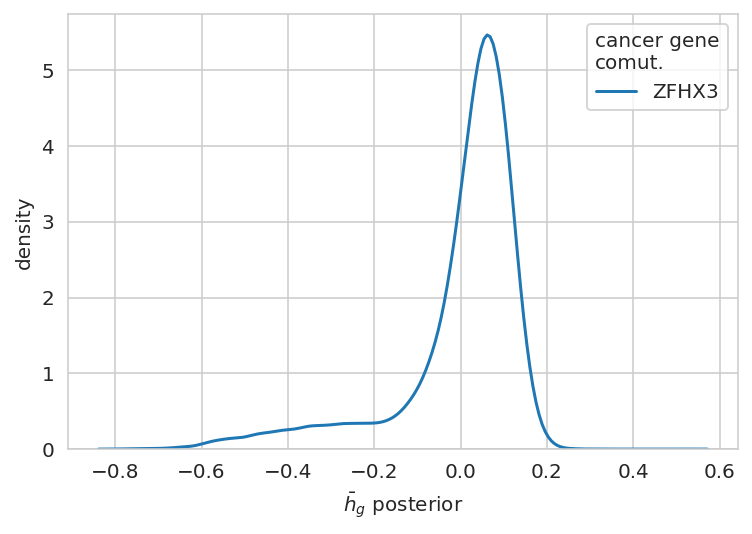

In [39]:
h_post_summary = (
    prostate_post_summary.query("var_name == 'h'")
    .reset_index(drop=True)
    .pipe(
        extract_coords_param_names,
        names=["hugo_symbol", "cancer_gene"],
        col="parameter",
    )
)

ax = sns.kdeplot(data=h_post_summary, x="mean", hue="cancer_gene")
ax.set_xlabel(r"$\bar{h}_g$ posterior")
ax.set_ylabel("density")
ax.get_legend().set_title("cancer gene\ncomut.")
plt.show()

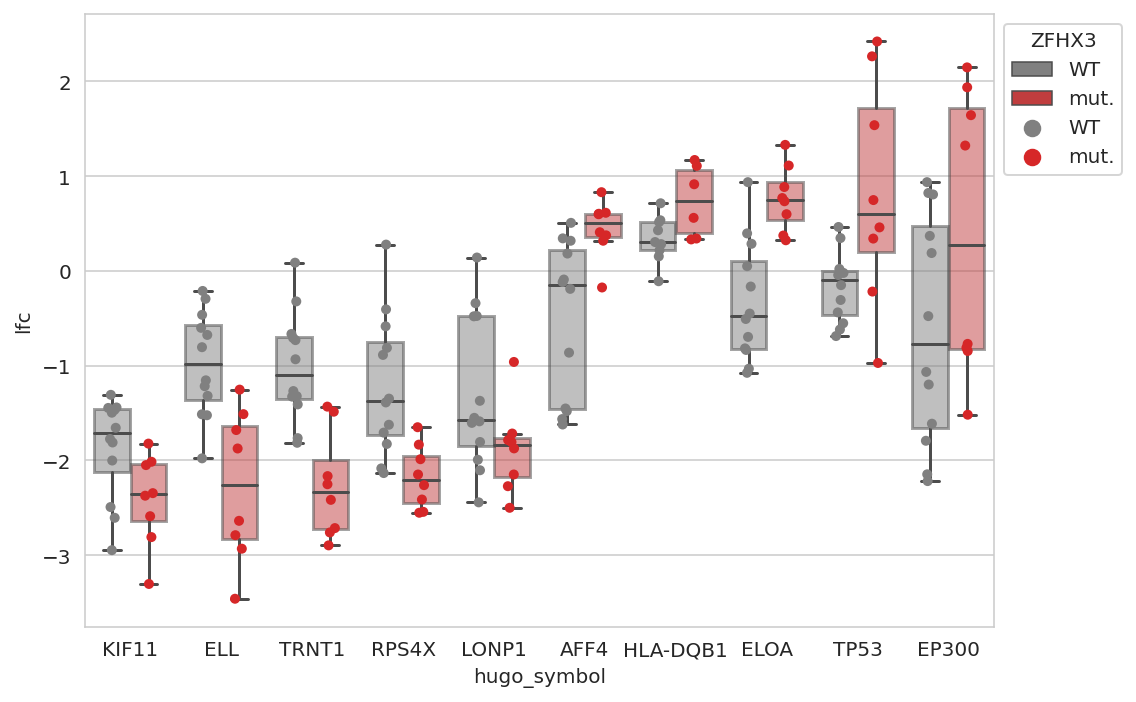

In [40]:
fig, axes = plt.subplots(
    len(cancer_genes), 1, squeeze=False, figsize=(8, len(cancer_genes) * 5)
)
for ax, cg in zip(axes.flatten(), cancer_genes):
    h_hits = (
        h_post_summary.filter_column_isin("cancer_gene", [cg])
        .sort_values("mean")
        .pipe(head_tail, n=5)["hugo_symbol"]
        .tolist()
    )

    h_hits_data = (
        valid_prostate_data.filter_column_isin("hugo_symbol", h_hits)
        .merge(cancer_gene_mutants.reset_index(), on="depmap_id")
        .reset_index()
        .astype({"hugo_symbol": str})
        .assign(
            hugo_symbol=lambda d: pd.Categorical(d["hugo_symbol"], categories=h_hits),
            _cg_mut=lambda d: d[cg].map({"X": "mut.", "": "WT"}),
        )
    )
    mut_pal = {"mut.": "tab:red", "WT": "gray"}
    sns.boxplot(
        data=h_hits_data,
        x="hugo_symbol",
        y="lfc",
        hue="_cg_mut",
        palette=mut_pal,
        ax=ax,
        showfliers=False,
        boxprops={"alpha": 0.5},
    )
    sns.stripplot(
        data=h_hits_data,
        x="hugo_symbol",
        y="lfc",
        hue="_cg_mut",
        dodge=True,
        palette=mut_pal,
        ax=ax,
    )
    sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1), title=cg)

plt.tight_layout()
plt.show()

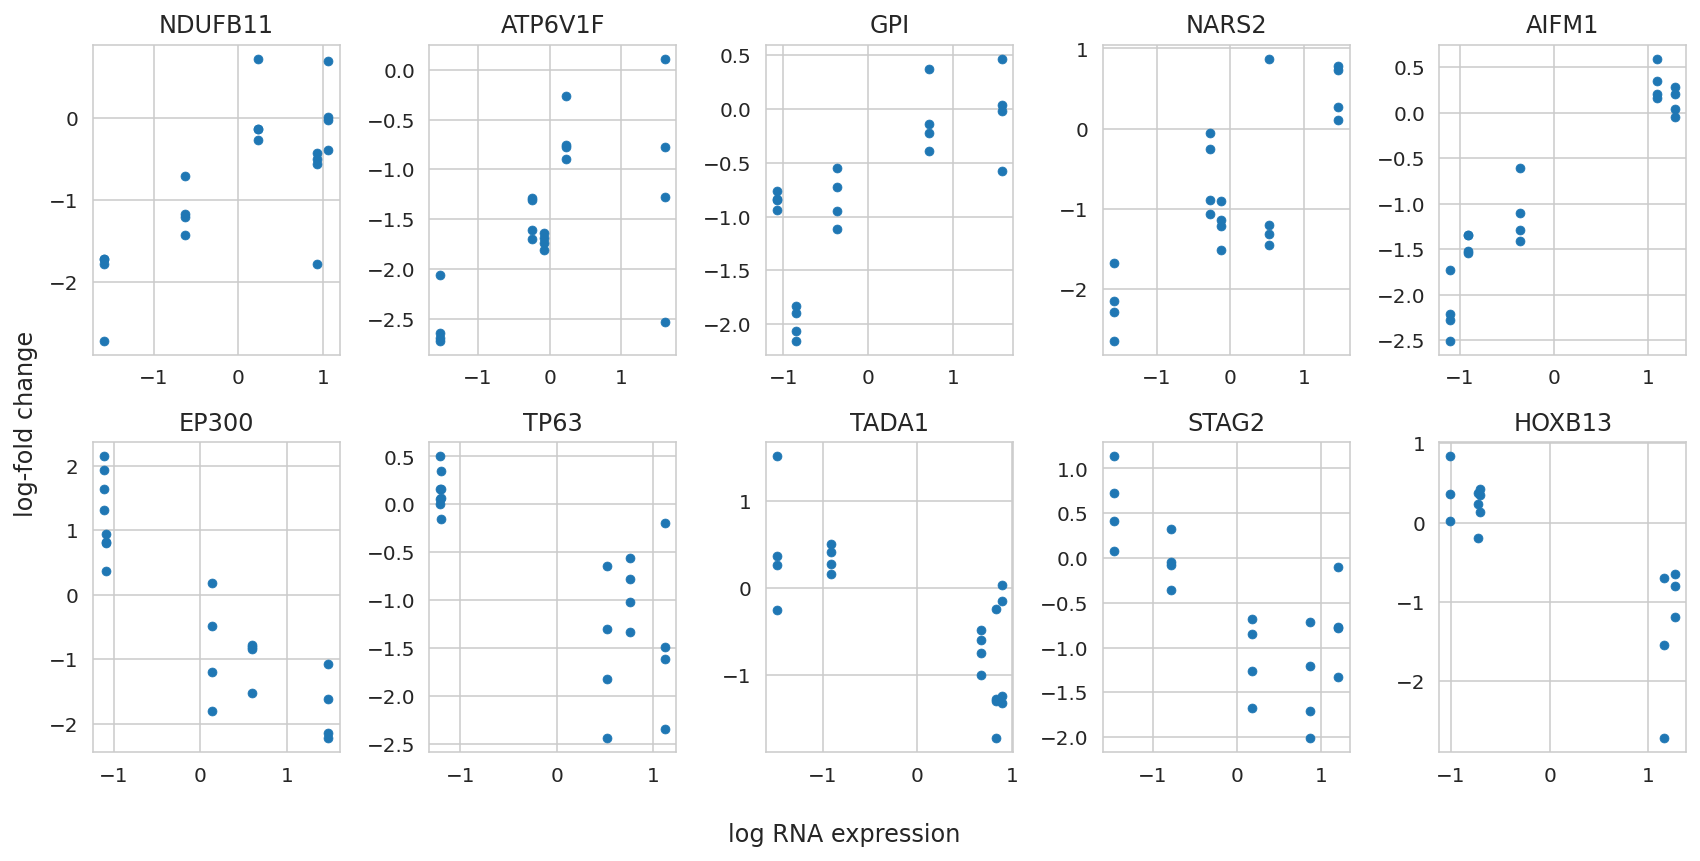

In [41]:
top_n = 5
top_b_hits = (
    prostate_post_summary.query("var_name == 'b'")
    .sort_values("mean")
    .reset_index(drop=True)
    .pipe(extract_coords_param_names, names=["hugo_symbol"], col="parameter")
    .pipe(head_tail, n=top_n)
)

negative_b = top_b_hits["hugo_symbol"][:top_n].values
positive_b = top_b_hits["hugo_symbol"][top_n:].values


fig, axes = plt.subplots(2, top_n, figsize=(12, 6))

for i, genes in enumerate([positive_b, negative_b]):
    for j, gene in enumerate(genes):
        ax = axes[i, j]
        ax.set_title(gene)
        obs_data = valid_prostate_data.query(f"hugo_symbol == '{gene}'")
        sns.scatterplot(
            data=obs_data, x="m_rna_gene", y="lfc", ax=ax, edgecolor=None, s=20
        )
        ax.set_xlabel(None)
        ax.set_ylabel(None)


fig.supxlabel("log RNA expression")
fig.supylabel("log-fold change")

fig.tight_layout()
plt.show()

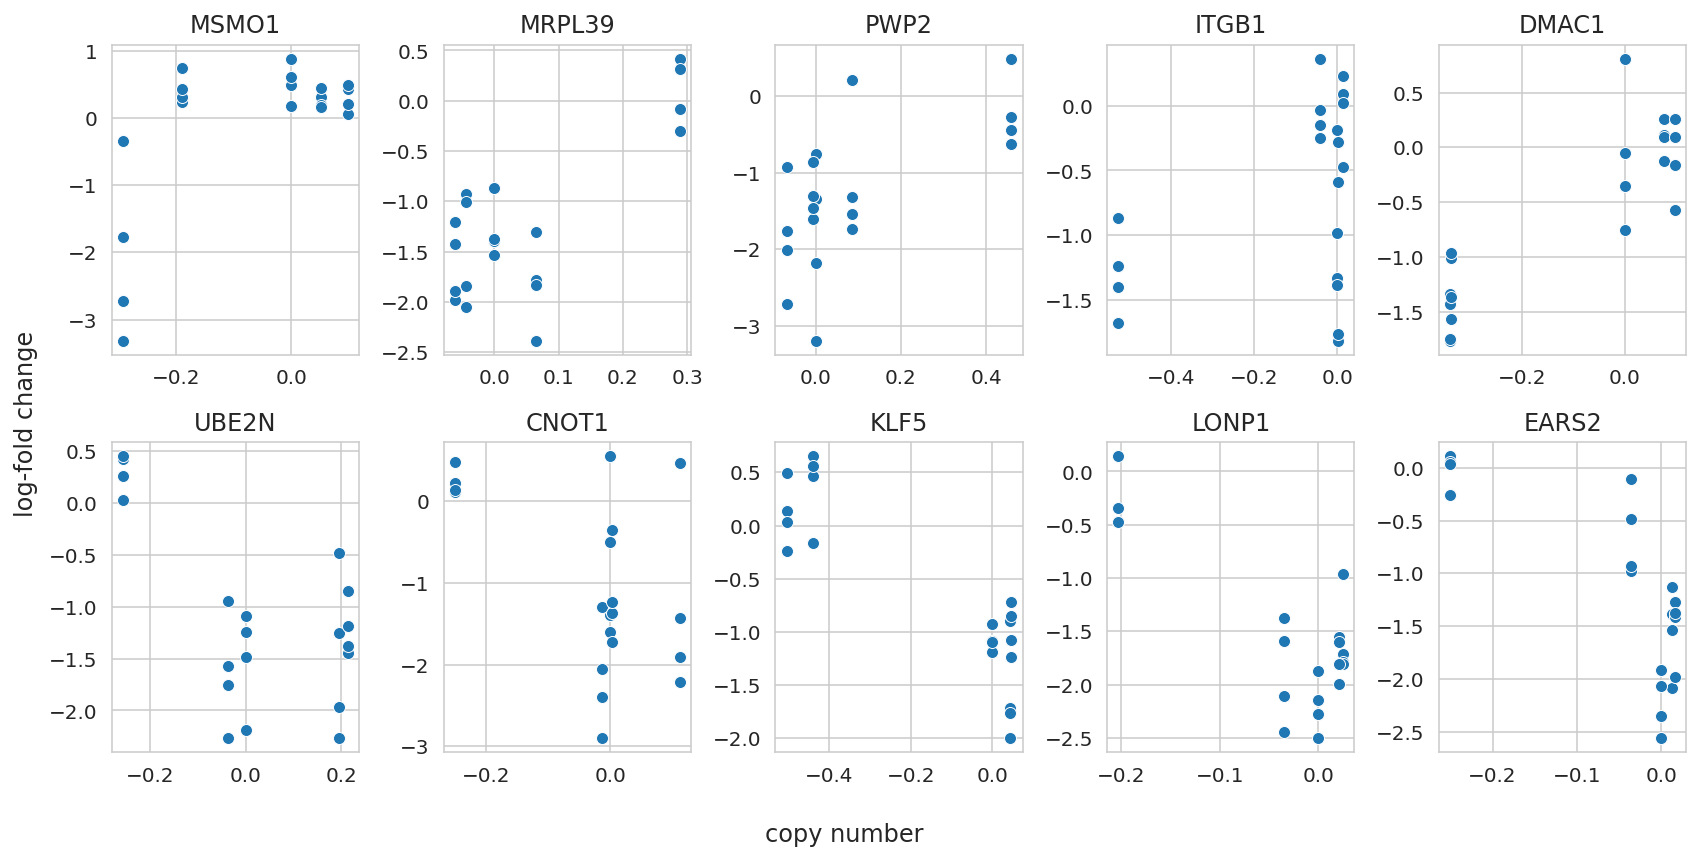

In [42]:
top_n = 5
top_d_hits = (
    prostate_post_summary.query("var_name == 'd'")
    .sort_values("mean")
    .reset_index(drop=True)
    .pipe(extract_coords_param_names, names=["hugo_symbol"], col="parameter")
    .pipe(head_tail, n=top_n)
)

negative_d = top_d_hits["hugo_symbol"][:top_n].values
positive_d = top_d_hits["hugo_symbol"][top_n:].values


fig, axes = plt.subplots(2, top_n, figsize=(12, 6))

for i, genes in enumerate([positive_d, negative_d]):
    for j, gene in enumerate(genes):
        ax = axes[i, j]
        ax.set_title(gene)
        obs_data = valid_prostate_data.query(f"hugo_symbol == '{gene}'")
        sns.scatterplot(data=obs_data, x="cn_gene", y="lfc", ax=ax)
        ax.set_xlabel(None)
        ax.set_ylabel(None)


fig.supxlabel("copy number")
fig.supylabel("log-fold change")
fig.tight_layout()
plt.show()

## PPC

In [43]:
n_examples = 40
n_chains, n_draws, n_data = trace.posterior_predictive["ct_final"].shape
ex_draws_idx = np.random.choice(
    np.arange(n_draws), size=n_examples // n_chains, replace=False
)
example_ppc_draws = trace.posterior_predictive["ct_final"][
    :, ex_draws_idx, :
].values.reshape(-1, n_data)
example_ppc_draws.shape

(40, 355308)

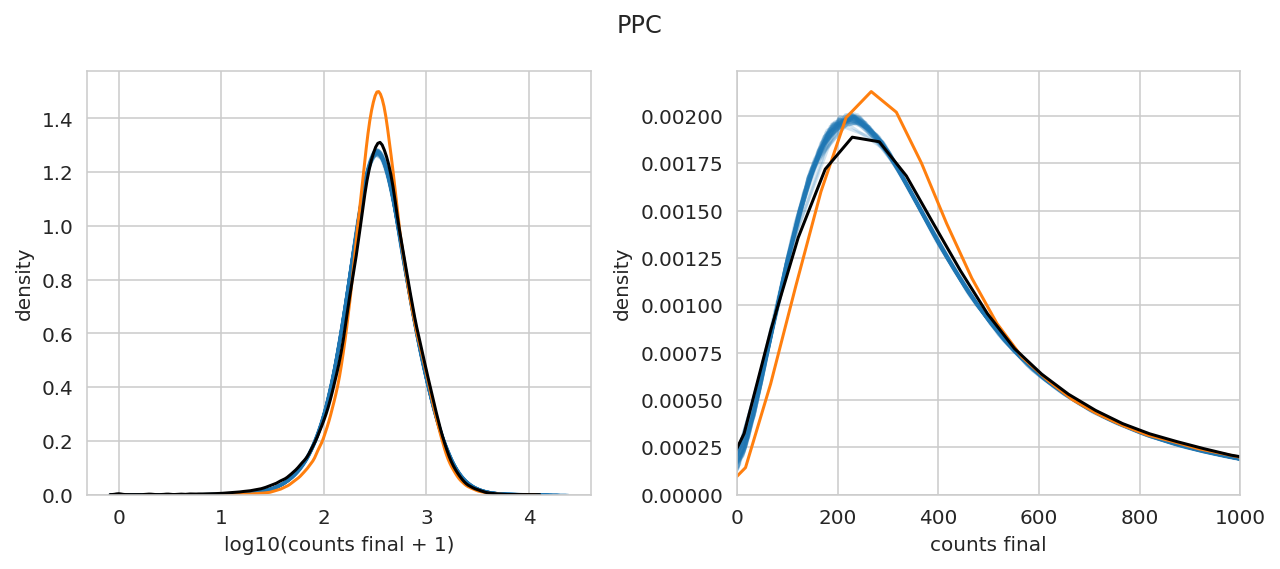

In [44]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharex=False, sharey=False)
ax1 = axes[0]
ax2 = axes[1]

pp_avg = trace.posterior_predictive["ct_final"].mean(axis=(0, 1))

for i in range(example_ppc_draws.shape[0]):
    sns.kdeplot(
        x=np.log10(example_ppc_draws[i, :] + 1), alpha=0.2, color="tab:blue", ax=ax1
    )

sns.kdeplot(x=np.log10(pp_avg + 1), color="tab:orange", ax=ax1)
sns.kdeplot(x=np.log10(valid_prostate_data["counts_final"] + 1), color="k", ax=ax1)
ax1.set_xlabel("log10(counts final + 1)")
ax1.set_ylabel("density")


for i in range(example_ppc_draws.shape[0]):
    sns.kdeplot(x=example_ppc_draws[i, :], alpha=0.2, color="tab:blue", ax=ax2)

sns.kdeplot(x=pp_avg, color="tab:orange", ax=ax2)
sns.kdeplot(x=valid_prostate_data["counts_final"], color="k", ax=ax2)
ax2.set_xlabel("counts final")
ax2.set_ylabel("density")
ax2.set_xlim(0, 1000)

fig.suptitle("PPC")
fig.tight_layout()
plt.show()

---

## Session info

In [45]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 6.36 minutes


In [46]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-08-04

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 3.10.0-1160.45.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-229.o2.rc.hms.harvard.edu

Git branch: simplify

seaborn   : 0.11.2
pandas    : 1.4.3
matplotlib: 3.5.2
numpy     : 1.23.1
arviz     : 0.12.1

